In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data Preprocessing
from sklearn.preprocessing import LabelEncoder

# Scaling and Splitting
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.preprocessing import scale

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

# Modelling
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC


#Unbalance problems
from imblearn.over_sampling import SMOTE

# Evaluation
from sklearn.metrics import f1_score,accuracy_score, precision_score,recall_score
from sklearn.metrics import confusion_matrix, classification_report, plot_confusion_matrix, roc_curve,roc_auc_score



import warnings 
warnings.filterwarnings(action='ignore')
sns.set()

In [45]:
df = pd.read_csv("possibleDataset/weatherAUS.csv")
df.isnull().sum(), df.shape

(Date                 0
 Location             0
 MinTemp           1485
 MaxTemp           1261
 Rainfall          3261
 Evaporation      62790
 Sunshine         69835
 WindGustDir      10326
 WindGustSpeed    10263
 WindDir9am       10566
 WindDir3pm        4228
 WindSpeed9am      1767
 WindSpeed3pm      3062
 Humidity9am       2654
 Humidity3pm       4507
 Pressure9am      15065
 Pressure3pm      15028
 Cloud9am         55888
 Cloud3pm         59358
 Temp9am           1767
 Temp3pm           3609
 RainToday         3261
 RainTomorrow      3267
 dtype: int64,
 (145460, 23))

## Data Preprocessing

In [46]:
df = df[df['RainTomorrow'].notna() & df['RainToday'].notna() & df['Sunshine'].notna()]

### Categorical Data

In [47]:
df['Date'] = pd.to_datetime(df['Date'])
df0 = df.copy()
df = df.drop('RainTomorrow',axis=1)
df['Month'] = df['Date'].dt.month
df['RainTomorrow'] = df0['RainTomorrow'] 

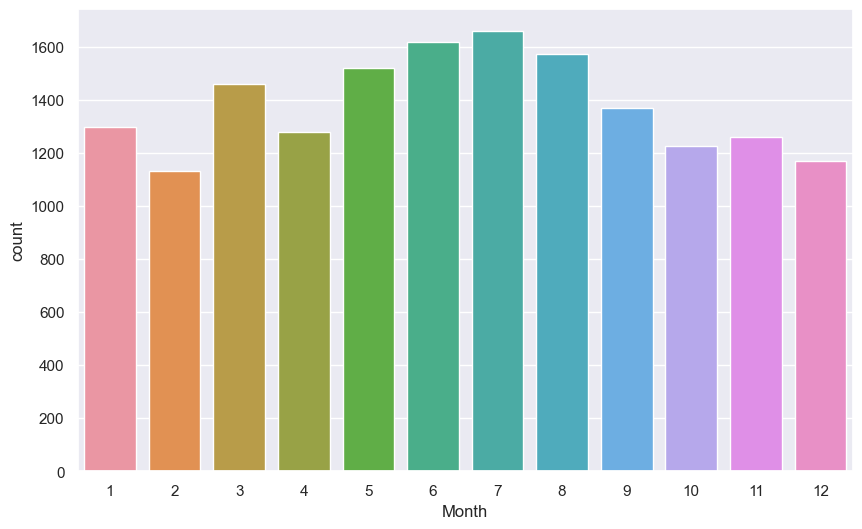

In [48]:
plt.figure(figsize=(10,6))
sns.countplot(data=df[df['RainTomorrow']=='Yes'],x='Month');

There are monts where the chances of raining increases, specially during summer

Location and Wind Directions are features that normaly have something to do with rains

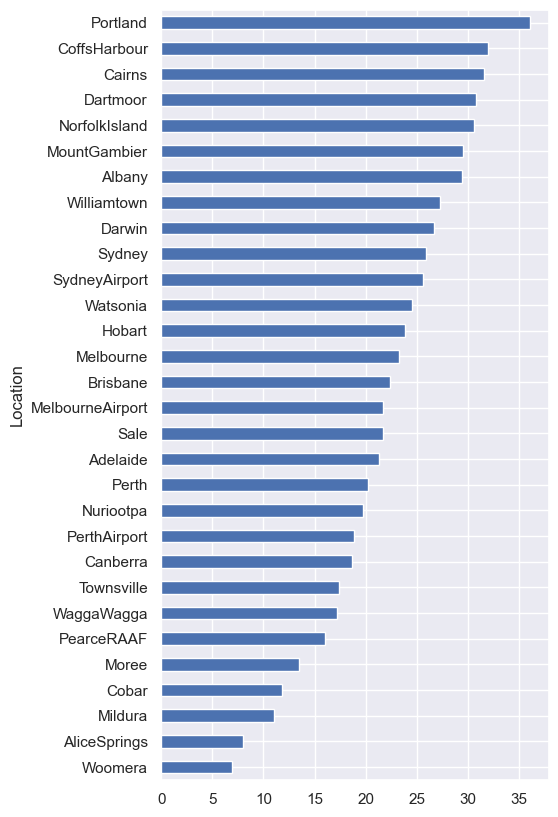

In [49]:
rainLoc_df=pd.crosstab(df['Location'],df['RainTomorrow']) 
# getting percentage of raining days and non raining days for each city 
rainLoc_df=rainLoc_df/rainLoc_df.transpose().sum().values.reshape((-1, 1))*100
rainLoc_sorted = rainLoc_df.sort_values(by='Yes',ascending=True )
rainLoc_sorted.Yes.plot(kind="barh",figsize=(5,10));

In [50]:
windgust_df=pd.crosstab(df['WindGustDir'],df['RainTomorrow']) 
windgust_df=windgust_df/windgust_df.transpose().sum().values.reshape((-1, 1))*100
windgust_df = windgust_df.sort_values(by='Yes',ascending=True )

In [51]:
winddir9am_df=pd.crosstab(df['WindDir9am'],df['RainTomorrow']) 
winddir9am_df=winddir9am_df/winddir9am_df.transpose().sum().values.reshape((-1, 1))*100
winddir9am_df = winddir9am_df.sort_values(by='Yes',ascending=True )

In [52]:
winddir3pm_df=pd.crosstab(df['WindDir3pm'],df['RainTomorrow']) 
winddir3pm_df=winddir3pm_df/winddir3pm_df.transpose().sum().values.reshape((-1, 1))*100
winddir3pm_df = winddir3pm_df.sort_values(by='Yes',ascending=True )

<AxesSubplot:>

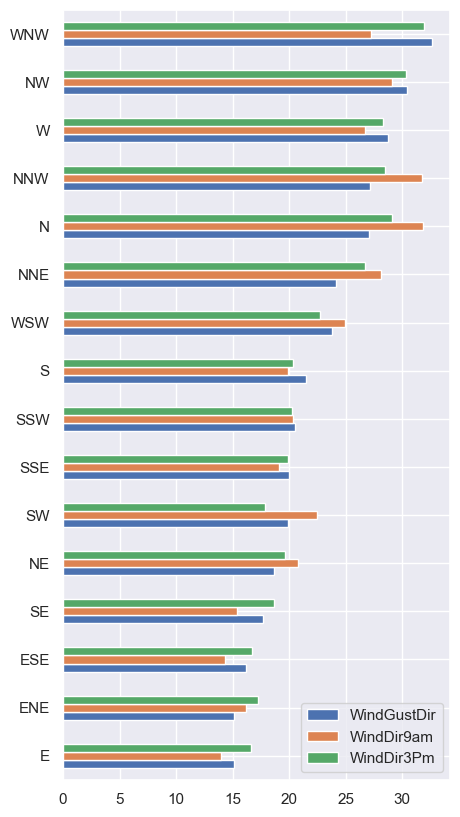

In [53]:
windDirs = pd.concat([windgust_df.Yes, winddir9am_df.Yes, winddir3pm_df.Yes], axis=1)
windDirs.columns = ['WindGustDir','WindDir9am','WindDir3Pm']
windDirs.plot(kind="barh",figsize=(5,10))

In [54]:
location_label_maping={}
for n, location in enumerate(rainLoc_sorted.index):
    location_label_maping[location] = n
df['Location'] = df['Location'].map(location_label_maping) 


windir_label_maping={}
for n, windir in enumerate(windDirs.index):
    windir_label_maping[windir] = n
df['WindGustDir'] = df['WindGustDir'].map(windir_label_maping)  
df['WindDir9am'] = df['WindDir9am'].map(windir_label_maping)  
df['WindDir3pm'] = df['WindDir3pm'].map(windir_label_maping)  

df['RainToday'] = df['RainToday'].map({'No':0, 'Yes':1})  

In [55]:
categorical = ['WindGustDir','WindDir9am','WindDir3pm','Location','RainToday']
df_labeled =  df.drop(['Date'],axis=1)
df_labeled.columns

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'Month', 'RainTomorrow'],
      dtype='object')

### Handling Outliers 

In [56]:
def box_plot(dataf_outliers, df_no_outliers):
    plt.figure(figsize=(10,4))
    fig, axes = plt.subplots(1, 2, figsize=(11, 5))
    sns.boxplot(data=dataf_outliers.values, palette='pastel', ax = axes[0])
    axes[0].set_title(f'Box Plot: {dataf_outliers.name} - With Outliers')
    sns.boxplot(data=df_no_outliers.values, palette='pastel', ax = axes[1])
    axes[1].set_title(f'Box Plot: {df_no_outliers.name} - Without Outliers')  
    plt.show()


def drop_outliers(dataf, colname):
    dfcol = dataf[colname]
    dfcol = dfcol[~np.isnan(dfcol)]
    iqr = 1.5*(np.percentile(dfcol,75)-np.percentile(dfcol,25))
    
    dataf.drop(dataf[dataf[colname] > (iqr + np.percentile(dfcol,75))].index, inplace=True)
    dataf.drop(dataf[dataf[colname] < (np.percentile(dfcol,25)-iqr)].index, inplace=True)
    return dataf[colname]

outliers: (73905,), no outliers: (73967,)


<Figure size 1000x400 with 0 Axes>

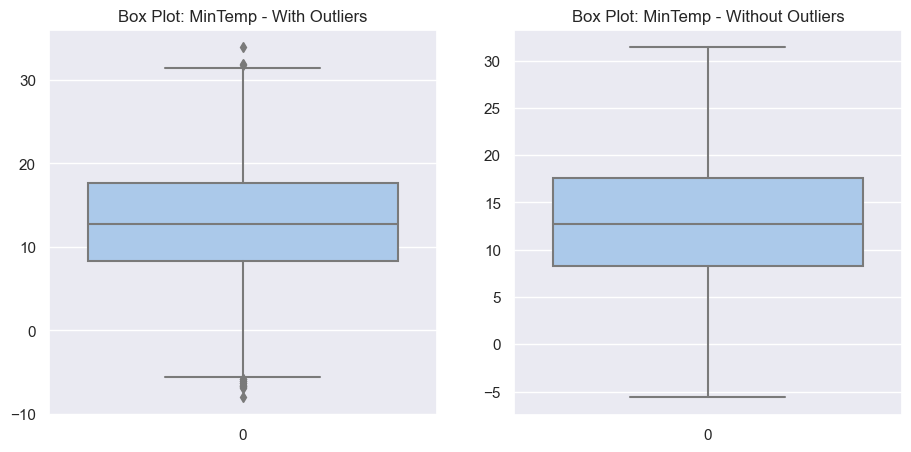

outliers: (73923,), no outliers: (73945,)


<Figure size 1000x400 with 0 Axes>

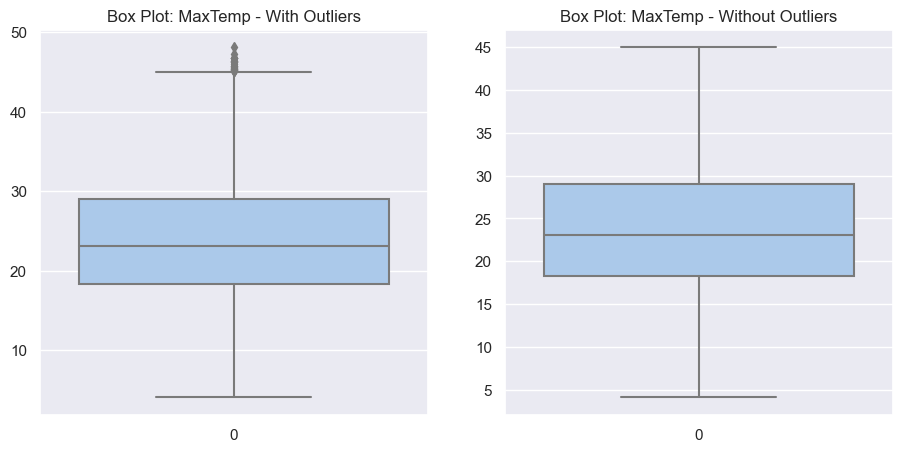

outliers: (73945,), no outliers: (60602,)


<Figure size 1000x400 with 0 Axes>

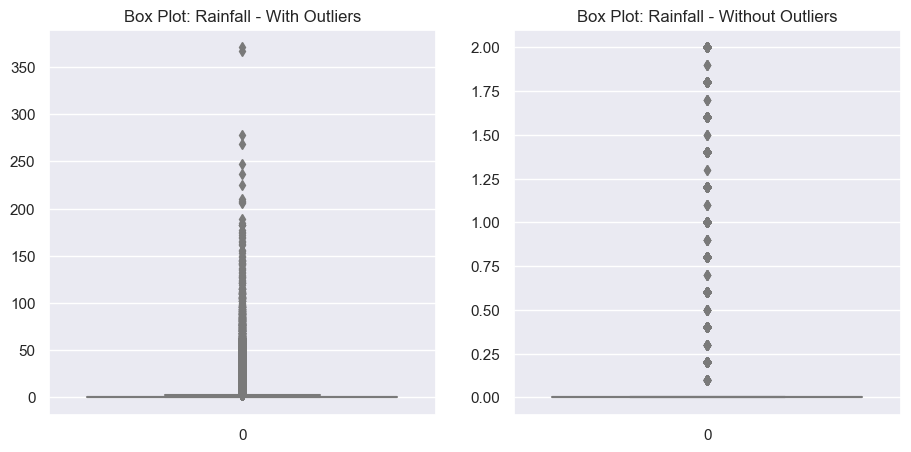

outliers: (57642,), no outliers: (59349,)


<Figure size 1000x400 with 0 Axes>

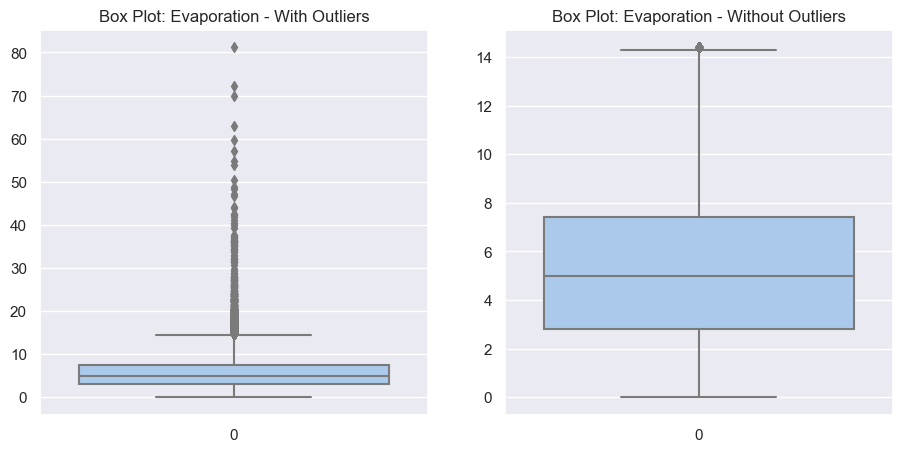

outliers: (59349,), no outliers: (59349,)


<Figure size 1000x400 with 0 Axes>

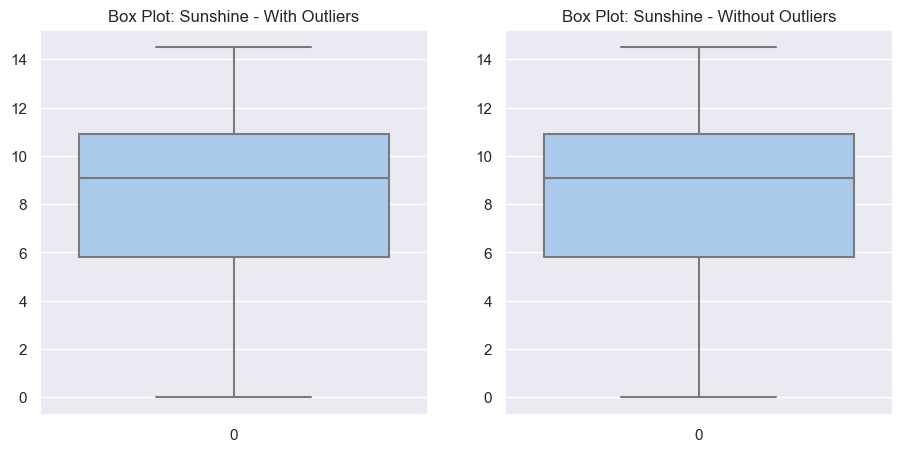

outliers: (56008,), no outliers: (57448,)


<Figure size 1000x400 with 0 Axes>

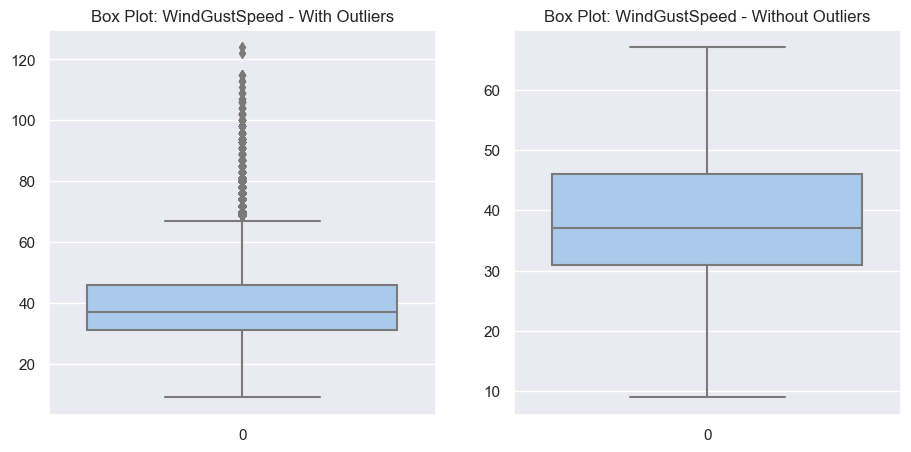

outliers: (57334,), no outliers: (56737,)


<Figure size 1000x400 with 0 Axes>

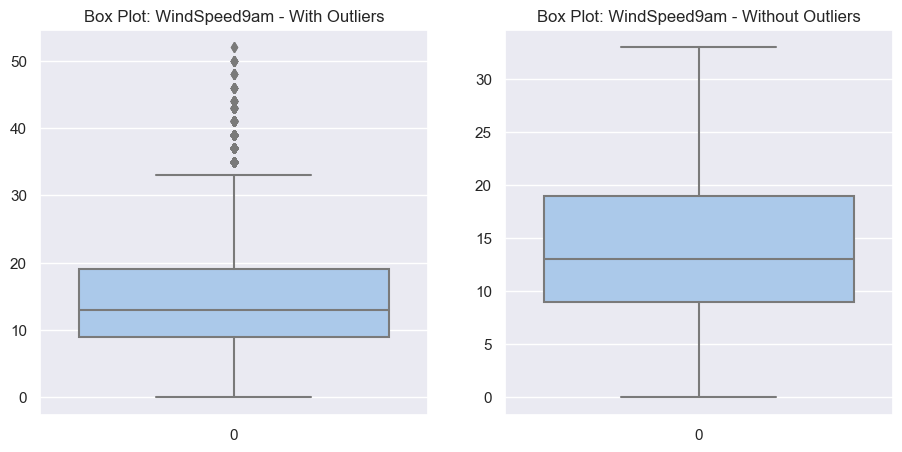

outliers: (56449,), no outliers: (56453,)


<Figure size 1000x400 with 0 Axes>

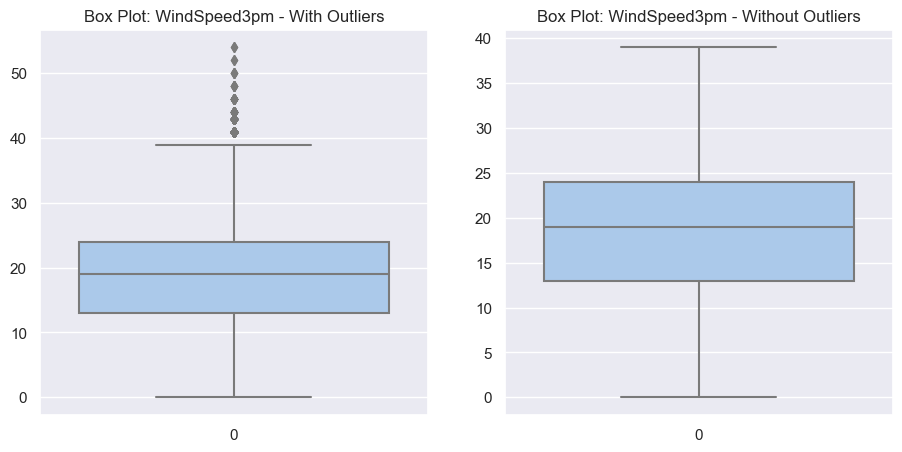

outliers: (56175,), no outliers: (55651,)


<Figure size 1000x400 with 0 Axes>

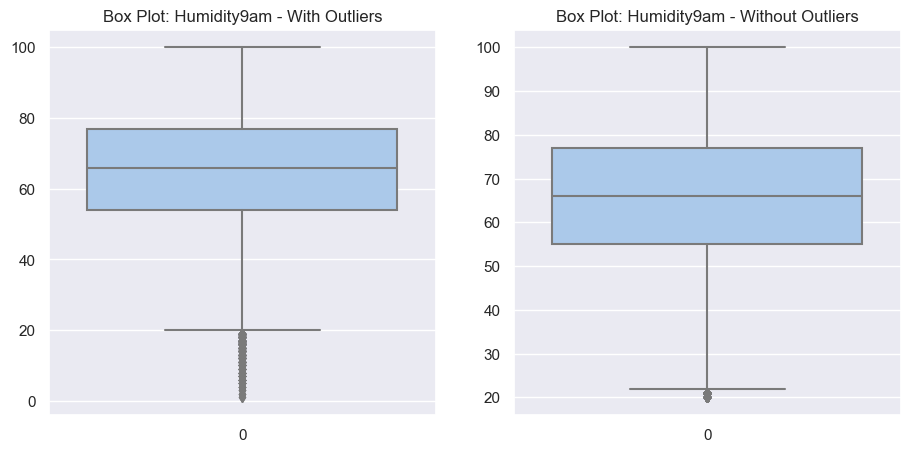

outliers: (55230,), no outliers: (55651,)


<Figure size 1000x400 with 0 Axes>

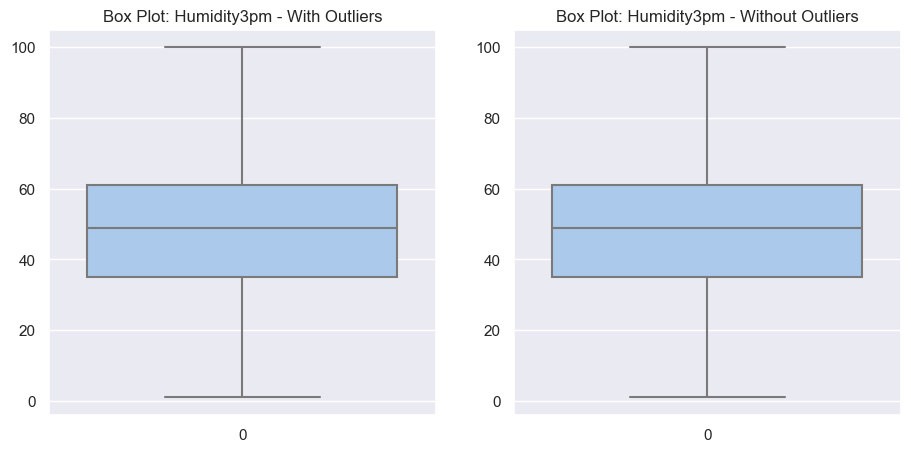

outliers: (55564,), no outliers: (55257,)


<Figure size 1000x400 with 0 Axes>

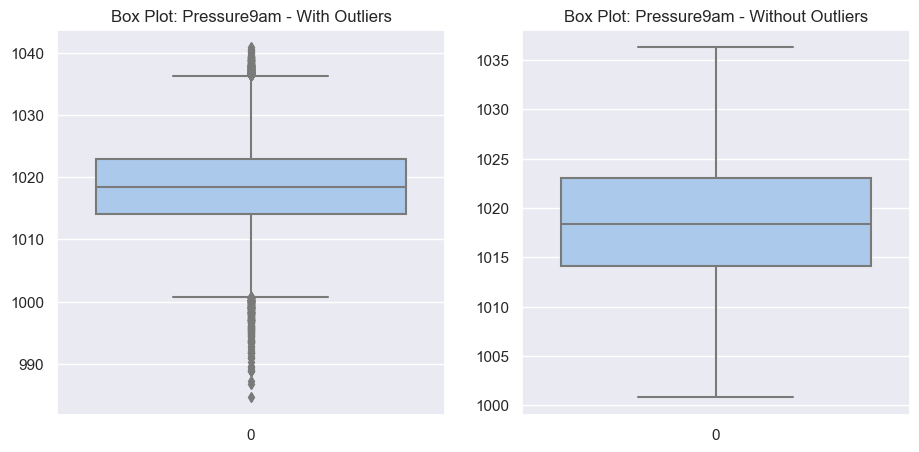

outliers: (55168,), no outliers: (55137,)


<Figure size 1000x400 with 0 Axes>

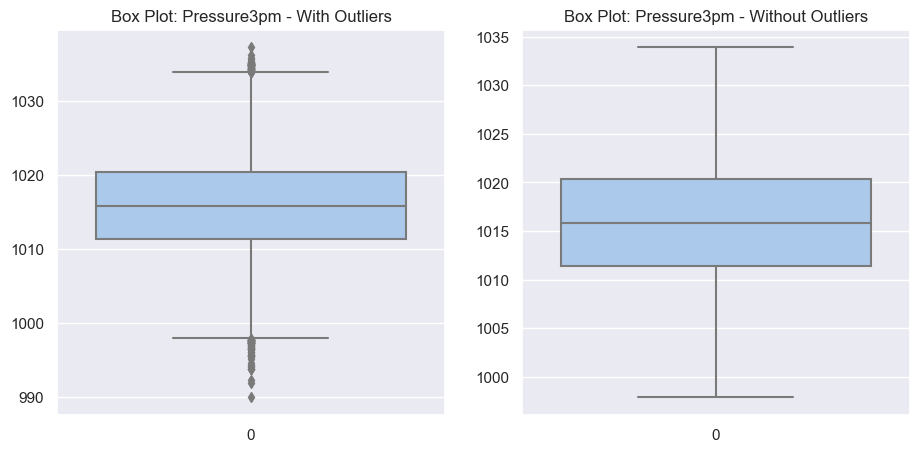

outliers: (49393,), no outliers: (55137,)


<Figure size 1000x400 with 0 Axes>

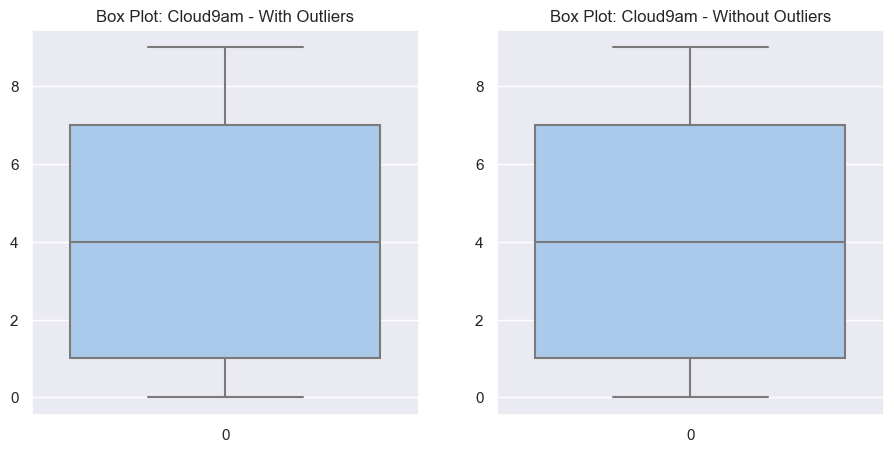

outliers: (48148,), no outliers: (55137,)


<Figure size 1000x400 with 0 Axes>

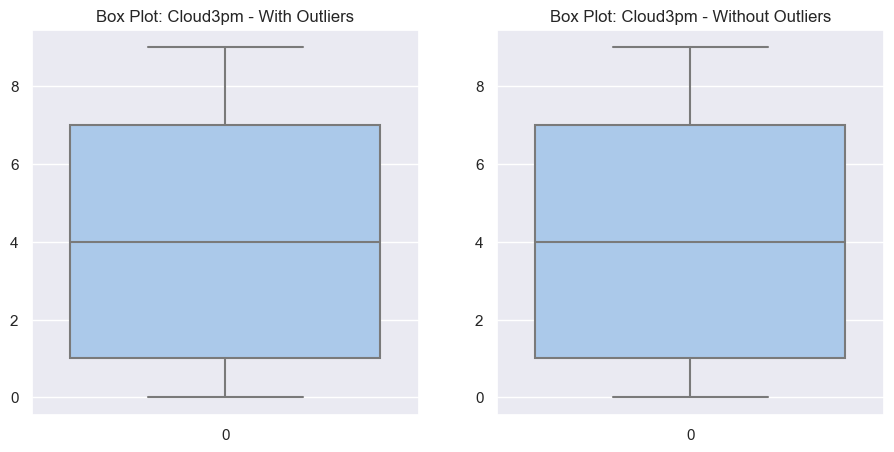

outliers: (55061,), no outliers: (55135,)


<Figure size 1000x400 with 0 Axes>

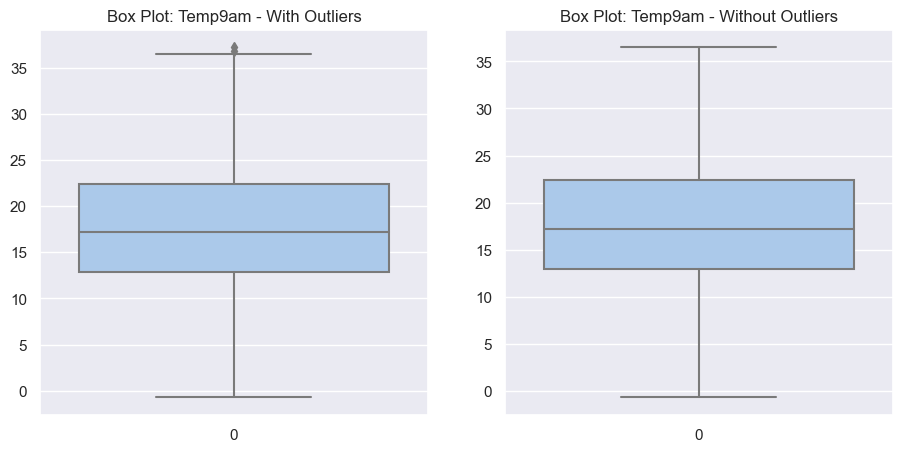

outliers: (54892,), no outliers: (55104,)


<Figure size 1000x400 with 0 Axes>

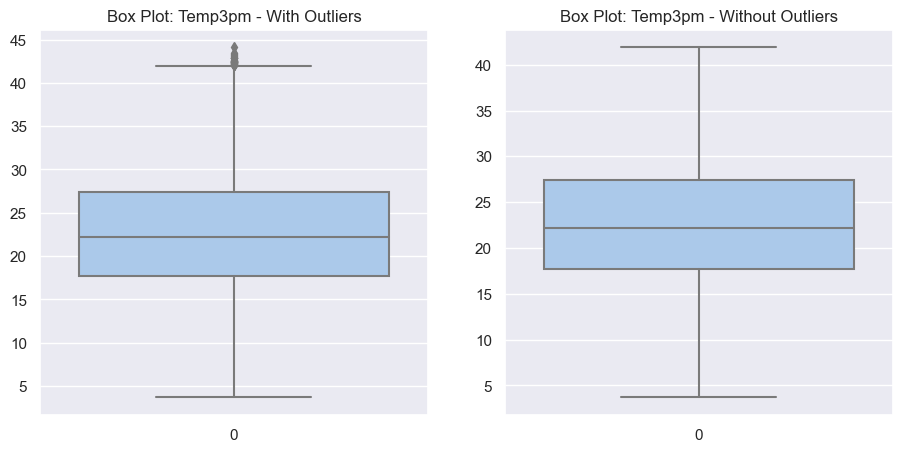

outliers: (55104,), no outliers: (55104,)


<Figure size 1000x400 with 0 Axes>

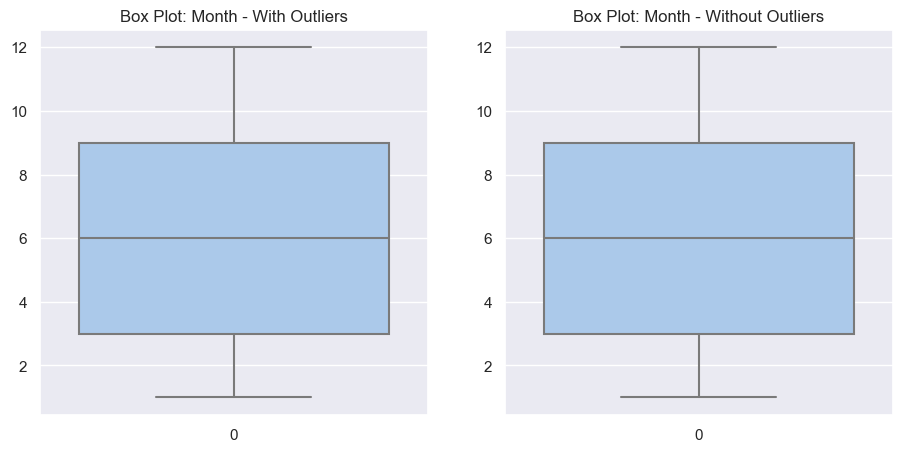

In [57]:
for col in df_labeled.columns:
    if col not in categorical + ['RainTomorrow']:
        dfcol = df_labeled[col]
        dfcol = dfcol[~np.isnan(dfcol)]
        df_no_outliers = drop_outliers(df_labeled, col)
        print(f'outliers: {dfcol.shape}, no outliers: {df_no_outliers.shape}')
        box_plot(dfcol, df_no_outliers)

### Handling Missing Values

In [58]:
def fill_mean(datacol):
    dataunique = datacol.unique()
    dataunique = dataunique[~np.isnan(dataunique)]
    data_mean = np.mean(dataunique)
    return datacol.fillna(data_mean)

In [59]:
for col in df_labeled.columns:
    if col not in ['RainTomorrow']:
        df_labeled[col] = fill_mean(df_labeled[col])

In [60]:
df_labeled.isnull().sum()

Location         0
MinTemp          0
MaxTemp          0
Rainfall         0
Evaporation      0
Sunshine         0
WindGustDir      0
WindGustSpeed    0
WindDir9am       0
WindDir3pm       0
WindSpeed9am     0
WindSpeed3pm     0
Humidity9am      0
Humidity3pm      0
Pressure9am      0
Pressure3pm      0
Cloud9am         0
Cloud3pm         0
Temp9am          0
Temp3pm          0
RainToday        0
Month            0
RainTomorrow     0
dtype: int64

In [61]:
df_labeled['RainTomorrow'] = df_labeled['RainTomorrow'].map({'No':0, 'Yes':1})  
X = df_labeled.drop('RainTomorrow',axis=1)
y = df_labeled['RainTomorrow']
X.shape

(55104, 22)

In [62]:
df_labeled0 = df_labeled.groupby('RainTomorrow', group_keys=False).apply(lambda x: x.sample(frac=0.1))
X = df_labeled0.drop('RainTomorrow',axis=1)
y = df_labeled0['RainTomorrow']
df_labeled0.head()

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
106527         0     10.8     22.4       0.0         11.0      10.3   
65387         14      8.2     16.5       0.2          3.2       6.0   
37673          6     14.8     28.0       0.0          6.4      11.0   
118261         9      8.8     27.2       0.0          5.4      11.1   
75762         29     12.0     17.8       0.2          3.4       7.7   

        WindGustDir  WindGustSpeed  WindDir9am  WindDir3pm  ...  Humidity3pm  \
106527          8.0           46.0         3.0         7.0  ...         20.0   
65387           5.0           46.0        15.0         5.0  ...         53.0   
37673           0.0           37.0         0.0         4.0  ...         45.0   
118261          9.0           33.0         0.0         9.0  ...         45.0   
75762           7.0           46.0         3.0         6.0  ...         63.0   

        Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
106527       1023.5       1019.9       0.0       4.5     14.7     21.4   
65387        1018.7       1017.7       5.0       5.0     12.3     14.7   
37673        1018.4       1013.1       1.0       1.0     18.4     27.2   
118261       1024.4       1019.9       0.0       0.0     18.5     25.0   
75762        1027.3       1026.9       8.0       7.0     14.3     16.9   

        RainToday  Month  RainTomorrow  
106527          0      9             0  
65387           0      5             0  
37673           0      3             0  
118261          0      9             0  
75762           0      2             0  

[5 rows x 23 columns]

In [63]:
mayority_weight = y.value_counts()[0]/y.shape[0]
minority_weight = y.value_counts()[1]/y.shape[0]
print(mayority_weight, minority_weight)

0.8446460980036298 0.15535390199637023


### Unbalance problems

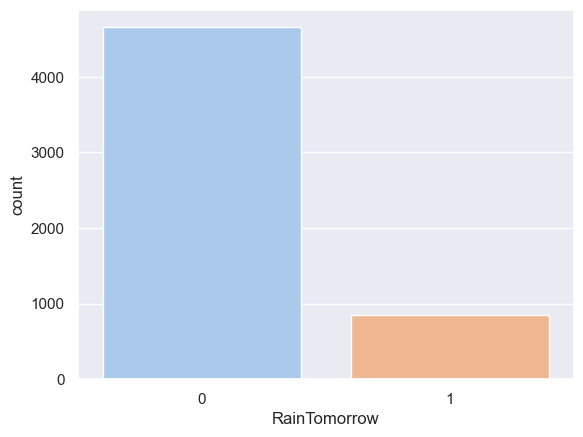

In [64]:
ax = sns.countplot(x=y, palette='pastel')

## Functions

In [65]:
def store_metrics(metr, ytest, ypr):
    metr[0].append(roc_auc_score(ytest, ypr))
    metr[1].append(f1_score(ytest, ypr))
    metr[2].append(precision_score(ytest, ypr))
    metr[3].append(recall_score(ytest, ypr))
    return metr

In [92]:
def calculate_KNN(Xtrain_resampled,Xtrain,ytrain_resampled,ytrain,Xtest,ytest, neighbors = 30):
    aucscores_resampled = []
    aucscores = []
    
    for k in range(1,neighbors):
        knn = KNeighborsClassifier(n_neighbors = k, weights='distance')
        knn.fit(Xtrain_resampled, ytrain_resampled)
        ypred_resampled = knn.predict(Xtest) 
        ## computing f1 score
        score = roc_auc_score(ytest, ypred_resampled)
        aucscores_resampled.append(score)
        
        knn = KNeighborsClassifier(n_neighbors = k,weights='distance')
        knn.fit(Xtrain, ytrain)
        ypred = knn.predict(Xtest) 
        ## computing f1 score
        score = roc_auc_score(ytest, ypred)
        aucscores.append(score)


    fig, axes = plt.subplots(1, 2, figsize=(11, 5))
    sns.set(font_scale = 1)
    sns.lineplot(y=aucscores_resampled, x=range(1,neighbors), ax = axes[0])
    axes[0].set_title('Balanced Dataset')
    axes[0].set(xlabel='Neighbors', ylabel='ROC-AUC Score')
    sns.lineplot(y=aucscores, x=range(1,neighbors), ax = axes[1])
    axes[1].set_title('Unbalanced Dataset')
    axes[1].set(xlabel='Neighbors', ylabel='ROC-AUC Score')
    
    return np.where(aucscores==np.max(aucscores))[0][0]+1,np.where(aucscores_resampled==np.max(aucscores_resampled))[0][0] +1


# FEATURE SUBSET SELECTION: MULTIVARIATE FILTER

In [67]:
df_labeled0.columns

Index(['Location', 'MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
       'WindGustDir', 'WindGustSpeed', 'WindDir9am', 'WindDir3pm',
       'WindSpeed9am', 'WindSpeed3pm', 'Humidity9am', 'Humidity3pm',
       'Pressure9am', 'Pressure3pm', 'Cloud9am', 'Cloud3pm', 'Temp9am',
       'Temp3pm', 'RainToday', 'Month', 'RainTomorrow'],
      dtype='object')

In [68]:
df_labeled0

Location  MinTemp  MaxTemp  Rainfall  Evaporation  Sunshine  \
106527         0     10.8     22.4       0.0         11.0      10.3   
65387         14      8.2     16.5       0.2          3.2       6.0   
37673          6     14.8     28.0       0.0          6.4      11.0   
118261         9      8.8     27.2       0.0          5.4      11.1   
75762         29     12.0     17.8       0.2          3.4       7.7   
...          ...      ...      ...       ...          ...       ...   
22816         25     17.9     21.8       1.4          5.2       4.2   
21267         25     13.5     19.8       0.0          2.4       4.3   
63010         13     13.5     29.3       0.0          5.4       5.7   
87559         27     23.6     30.9       2.0          6.2       7.2   
36066         19     17.5     21.0       0.0          7.8       3.4   

        WindGustDir  WindGustSpeed  WindDir9am  WindDir3pm  ...  Humidity3pm  \
106527          8.0           46.0         3.0         7.0  ...         20.0   
65387           5.0           46.0        15.0         5.0  ...         53.0   
37673           0.0           37.0         0.0         4.0  ...         45.0   
118261          9.0           33.0         0.0         9.0  ...         45.0   
75762           7.0           46.0         3.0         6.0  ...         63.0   
...             ...            ...         ...         ...  ...          ...   
22816           0.0           52.0         2.0         2.0  ...         75.0   
21267           1.0           19.0         7.5         6.0  ...         61.0   
63010           6.0           44.0        11.0         8.0  ...         68.0   
87559           1.0           37.0         6.0         0.0  ...         63.0   
36066           7.0           52.0         7.0         6.0  ...         93.0   

        Pressure9am  Pressure3pm  Cloud9am  Cloud3pm  Temp9am  Temp3pm  \
106527       1023.5       1019.9       0.0       4.5     14.7     21.4   
65387        1018.7       1017.7       5.0       5.0     12.3     14.7   
37673        1018.4       1013.1       1.0       1.0     18.4     27.2   
118261       1024.4       1019.9       0.0       0.0     18.5     25.0   
75762        1027.3       1026.9       8.0       7.0     14.3     16.9   
...             ...          ...       ...       ...      ...      ...   
22816        1009.3       1009.4       7.0       7.0     19.3     21.1   
21267        1018.8       1016.3       7.0       7.0     16.9     18.1   
63010        1012.9       1013.5       2.0       7.0     20.0     22.4   
87559        1013.5       1010.7       7.0       4.0     25.8     29.7   
36066        1017.5       1016.8       7.0       8.0     18.2     17.8   

        RainToday  Month  RainTomorrow  
106527          0      9             0  
65387           0      5             0  
37673           0      3             0  
118261          0      9             0  
75762           0      2             0  
...           ...    ...           ...  
22816           1     11             1  
21267           0      5             1  
63010           0      4             1  
87559           1     11             1  
36066           0      3             1  

[5510 rows x 23 columns]

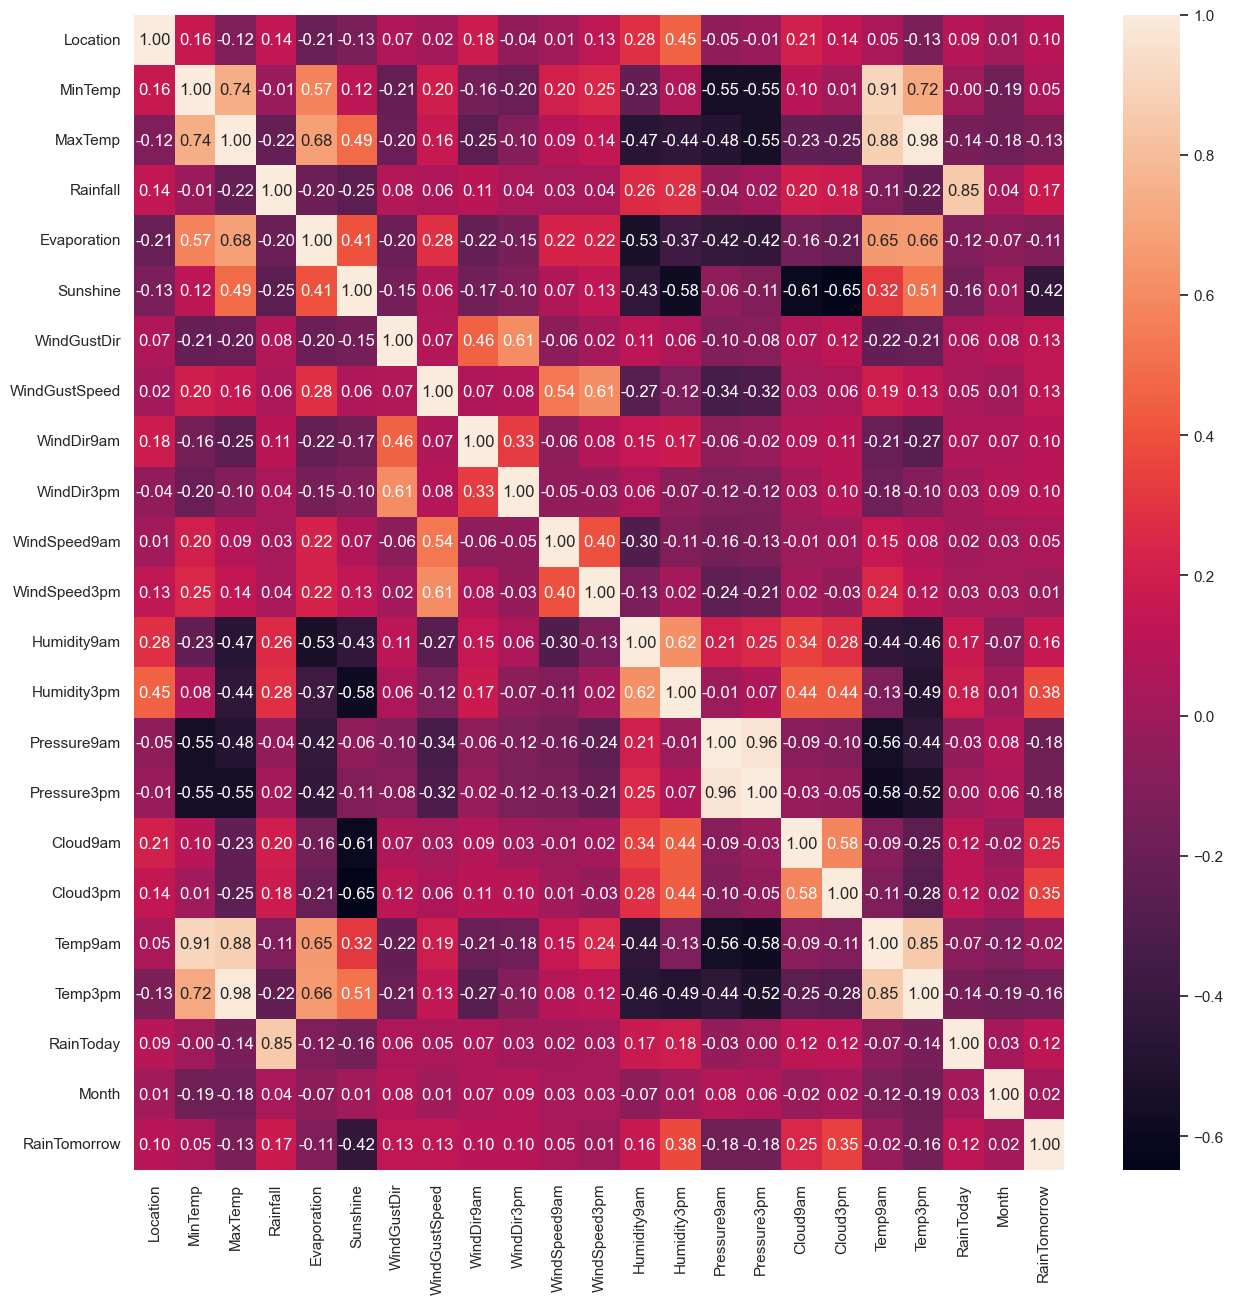

In [69]:
plt.figure(figsize=(15,15))
ax = sns.heatmap(df_labeled0.corr(), annot=True, fmt='.2f') 
plt.show()



# KNN

### SMOTE Oversampling

In [70]:

smote = SMOTE()
stscaler = StandardScaler()
#normalization
Xnorm = stscaler.fit_transform(X)
Xnorm = pd.DataFrame(Xnorm, columns=X.columns)
Xnorm.head()

Location   MinTemp   MaxTemp  Rainfall  Evaporation  Sunshine  WindGustDir  \
0 -1.750457 -0.289051 -0.239681 -0.403077     1.955326  0.599485     0.249178   
1 -0.069387 -0.699082 -1.137534  0.106842    -0.692935 -0.586016    -0.420237   
2 -1.029998  0.341764  0.612519 -0.403077     0.393531  0.792474    -1.535927   
3 -0.669769 -0.604459  0.490776 -0.403077     0.054010  0.820044     0.472316   
4  1.731759 -0.099807 -0.939702  0.106842    -0.625031 -0.117329     0.026040   

   WindGustSpeed  WindDir9am  WindDir3pm  ...  Humidity9am  Humidity3pm  \
0       0.819310   -0.848358    0.012528  ...    -1.624219    -1.517830   
1       0.819310    1.758336   -0.425758  ...     0.266118     0.252697   
2      -0.077561   -1.500032   -0.644901  ...    -0.324612    -0.176522   
3      -0.476169   -1.500032    0.450814  ...    -0.147393    -0.176522   
4       0.819310   -0.848358   -0.206615  ...     0.325191     0.789220   

   Pressure9am  Pressure3pm  Cloud9am  Cloud3pm   Temp9am   Temp3pm  \
0     0.760569     0.605591 -1.495645  0.180707 -0.457889 -0.181477   
1     0.000296     0.258923  0.383460  0.381574 -0.834748 -1.226471   
2    -0.047221    -0.465928 -1.119824 -1.225361  0.123103  0.723144   
3     0.903121     0.605591 -1.495645 -1.627095  0.138806  0.380012   
4     1.362452     1.708624  1.510923  1.185042 -0.520698 -0.883339   

   RainToday     Month  
0  -0.242069  0.795362  
1  -0.242069 -0.380738  
2  -0.242069 -0.968788  
3  -0.242069  0.795362  
4  -0.242069 -1.262813  

[5 rows x 22 columns]

In [80]:
from ITMO_FS.filters.multivariate import MultivariateFilter
k = 10

measures = ['MIM','MRMR','JMI','CIFE','MIFS','CMIM','ICAP','DCSF','CFR','MRI','IWFS']

multivar = MultivariateFilter('CFR', k)
multivar.fit(Xnorm, y)
Xnorm_new = multivar.transform(Xnorm)

In [81]:
selected_features = pd.DataFrame(Xnorm_new.columns, columns=['Features'])
drop_features = X.drop(selected_features.Features, axis=1)
selected_features

Features
0     Location
1  Pressure3pm
2      Temp9am
3  Pressure9am
4      Temp3pm
5      MinTemp
6      MaxTemp
7     Sunshine
8  Humidity9am
9  Humidity3pm

In [82]:
drop_features.columns

Index(['Rainfall', 'Evaporation', 'WindGustDir', 'WindGustSpeed', 'WindDir9am',
       'WindDir3pm', 'WindSpeed9am', 'WindSpeed3pm', 'Cloud9am', 'Cloud3pm',
       'RainToday', 'Month'],
      dtype='object')

In [83]:
X_new = X.drop(drop_features.columns, axis=1)
Xnorm_new = scale(X_new)
Xnorm_new = pd.DataFrame(Xnorm_new, columns=X_new.columns)

#split into train and test
Xtrain, Xtest, ytrain, ytest = train_test_split(Xnorm_new, y, test_size=0.2, random_state=13)
Xtrain_resampled, ytrain_resampled = smote.fit_resample(Xtrain, ytrain)
Xtrain.head()

Location   MinTemp   MaxTemp  Sunshine  Humidity9am  Humidity3pm  \
1039 -0.069387 -0.620230  0.064676  1.123312    -0.324612    -1.034959   
2443  0.891224 -1.361438 -0.924484  0.185939     0.266118     0.199044   
2434  0.651071 -0.225970  0.003805  0.627055    -0.501831    -1.088612   
127   0.410918 -0.115577  1.829946  1.316300     0.325191    -1.625135   
3420  1.011300 -0.108097 -0.117938  0.654625    -0.324612     0.118566   

      Pressure9am  Pressure3pm   Temp9am   Temp3pm  
1039    -0.934206    -1.364112 -0.552103  0.161655  
2443     0.222042     0.195892 -1.352930 -1.086098  
2434    -0.237289    -0.150775 -0.206649  0.114864  
127     -0.696621    -1.064717  0.075996  1.799331  
3420     0.253720     0.180135 -0.031166  0.198838

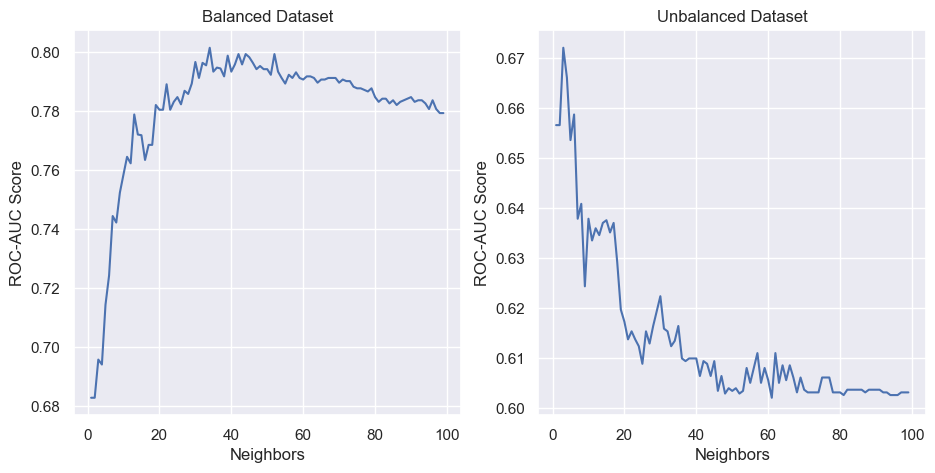

In [84]:
kmax, k_resampled_max = calculate_KNN(Xtrain_resampled,Xtrain,ytrain_resampled,ytrain,Xtest,ytest, neighbors = 100)

In [85]:
print(kmax, k_resampled_max)

3 34


In [86]:
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)
metrics_resampled = [[],[],[],[]]
metrics = [[],[],[],[]]
results_resampled = []
results = []
Xtrain0 = np.array(Xnorm_new)
ytrain0 = np.array(y)
for train_ix, test_ix in kfold.split(Xtrain0, ytrain0):
    # select rows
    train_X, test_X = Xtrain0[train_ix], Xtrain0[test_ix]
    train_y, test_y = ytrain0[train_ix], ytrain0[test_ix]
    
    # train unbalanced
    knn_unbalanced = KNeighborsClassifier(n_neighbors = kmax, weights='distance')
    knn_unbalanced.fit(train_X, train_y)
    ypred = knn_unbalanced.predict(test_X)
    
    metrics = store_metrics(metrics, test_y, ypred)
    results.append([test_y, ypred])
    
    
    # train balanced 
    Xtrain_resampled0, ytrain_resampled0 = smote.fit_resample(train_X, train_y)
    knn_balanced = KNeighborsClassifier(n_neighbors = k_resampled_max, weights='distance')
    knn_balanced.fit(Xtrain_resampled0, ytrain_resampled0)
    ypred_resampled = knn_balanced.predict(test_X)
    
    metrics_resampled = store_metrics(metrics_resampled, test_y, ypred_resampled)
    results_resampled.append([test_y, ypred_resampled])

In [87]:
metrics_resampled = np.array(metrics_resampled)
metrics = np.array(metrics)
results_resampled = np.array(results_resampled)
results = np.array(results)

columns_resampled = ['ROC_AUC_resampled','F1_resampled','Precision_resampled','Recall_resampled']
columns = ['ROC_AUC','F1','Precision','Recall']
metrics_scores = pd.DataFrame(np.concatenate([metrics_resampled.T, metrics.T],axis=1), columns = columns_resampled + columns)
mean_score = np.mean(np.array(metrics_scores), axis=0)
mean_score0 = pd.DataFrame(mean_score.round(3).reshape(2,4), columns = columns, index=['Balanced','Unbalanced'])
mean_score0

ROC_AUC     F1  Precision  Recall
Balanced      0.767  0.501      0.370   0.778
Unbalanced    0.674  0.475      0.585   0.401

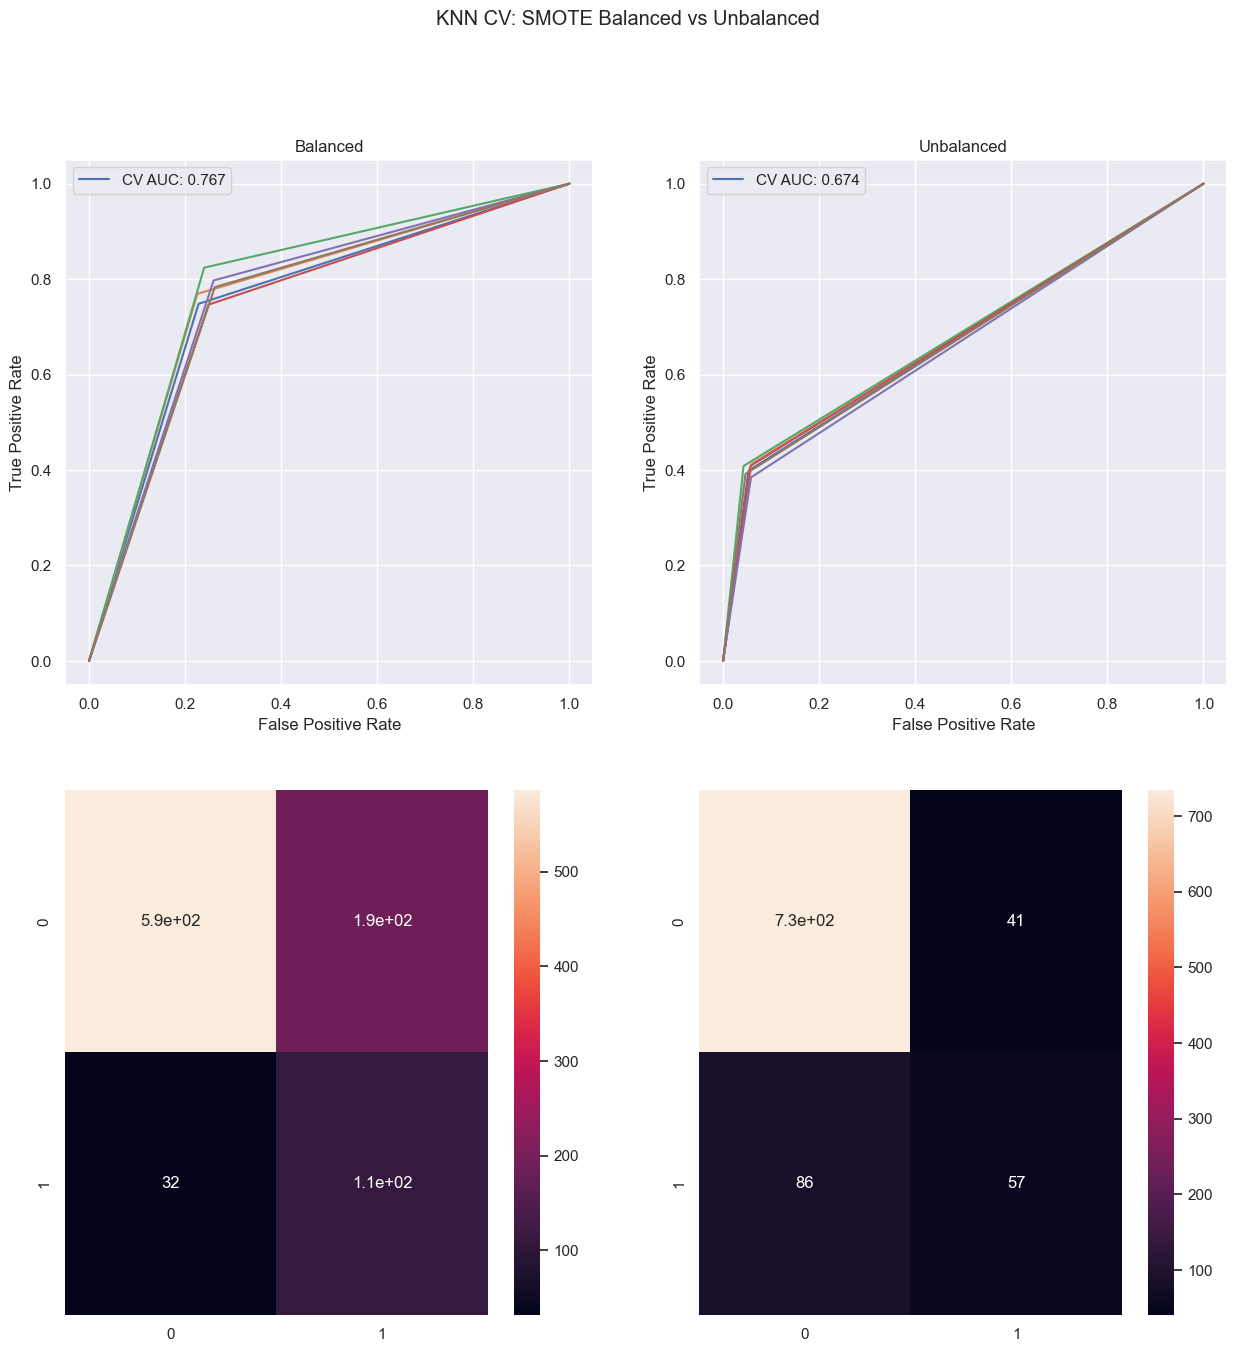

In [88]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle(f'KNN CV: SMOTE Balanced vs Unbalanced')
sns.set(font_scale = 1)

cflist = []
cflist_resampled = []
for res_resampled, res in zip(results_resampled, results):

    fpr, tpr, _ = roc_curve(res_resampled[0],  res_resampled[1])
    auc = roc_auc_score(res_resampled[0],  res_resampled[1])
    cf = confusion_matrix(res_resampled[0],  res_resampled[1])
    cflist_resampled.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,0])
    axes[0,0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,0].set_title('Balanced')

    
    
    fpr, tpr, _ = roc_curve(res[0],  res[1])
    auc = roc_auc_score(res[0],  res[1])
    cf = confusion_matrix(res[0],  res[1])
    cflist.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,1])
    axes[0,1].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,1].set_title('Unbalanced')
    
    
axes[0,0].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][0],3)}"])
axes[0,1].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][1],3)}"])

cf = np.mean(cflist,axis=0)
cf_resampled = np.mean(cflist_resampled,axis=0)
sns.heatmap(pd.DataFrame(cf_resampled) , annot=True, ax = axes[1,0])
sns.heatmap(pd.DataFrame(cf) , annot=True, ax = axes[1,1])   
plt.show()

    

### NearMiss Undersampling

In [93]:
from imblearn.under_sampling import NearMiss
nm = NearMiss()

X_new = X.drop(drop_features.columns, axis=1)
Xnorm_new = stscaler.fit_transform(X_new)
Xnorm_new = pd.DataFrame(Xnorm_new, columns=X_new.columns)

#split into train and test
Xtrain, Xtest, ytrain, ytest = train_test_split(Xnorm_new, y, test_size=0.2, random_state=13)
Xtrain_resampled, ytrain_resampled = nm.fit_resample(Xtrain, ytrain)

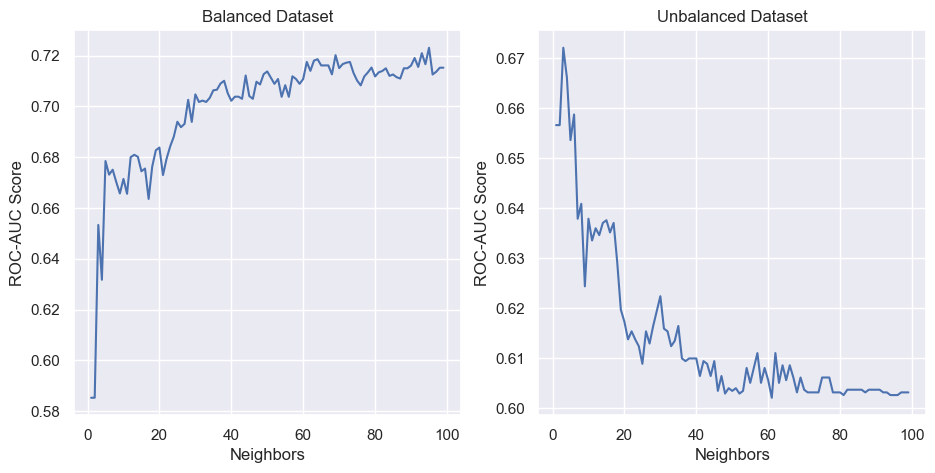

In [94]:
kmax, k_resampled_max = calculate_KNN(Xtrain_resampled,Xtrain,ytrain_resampled,ytrain,Xtest,ytest, neighbors = 100)

In [96]:
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)
metrics_resampled = [[],[],[],[]]
metrics = [[],[],[],[]]
results_resampled = []
results = []
Xtrain0 = np.array(Xnorm_new)
ytrain0 = np.array(y)
for train_ix, test_ix in kfold.split(Xtrain0, ytrain0):
    # select rows
    train_X, test_X = Xtrain0[train_ix], Xtrain0[test_ix]
    train_y, test_y = ytrain0[train_ix], ytrain0[test_ix]
    
    # train unbalanced
    knn_unbalanced = KNeighborsClassifier(n_neighbors = kmax, weights='distance')
    knn_unbalanced.fit(train_X, train_y)
    ypred = knn_unbalanced.predict(test_X)
    
    metrics = store_metrics(metrics, test_y, ypred)
    results.append([test_y, ypred])
    
    
    # train balanced 
    Xtrain_resampled0, ytrain_resampled0 = nm.fit_resample(train_X, train_y)
    knn_balanced = KNeighborsClassifier(n_neighbors = k_resampled_max, weights='distance')
    knn_balanced.fit(Xtrain_resampled0, ytrain_resampled0)
    ypred_resampled = knn_balanced.predict(test_X)
    
    metrics_resampled = store_metrics(metrics_resampled, test_y, ypred_resampled)
    results_resampled.append([test_y, ypred_resampled])

In [97]:
metrics_resampled = np.array(metrics_resampled)
metrics = np.array(metrics)
results_resampled = np.array(results_resampled)
results = np.array(results)

columns_resampled = ['ROC_AUC_resampled','F1_resampled','Precision_resampled','Recall_resampled']
columns = ['ROC_AUC','F1','Precision','Recall']
metrics_scores = pd.DataFrame(np.concatenate([metrics_resampled.T, metrics.T],axis=1), columns = columns_resampled + columns)
mean_score = np.mean(np.array(metrics_scores), axis=0)
mean_score0 = pd.DataFrame(mean_score.round(3).reshape(2,4), columns = columns, index=['Balanced','Unbalanced'])
mean_score0

ROC_AUC     F1  Precision  Recall
Balanced      0.720  0.511      0.479   0.551
Unbalanced    0.674  0.475      0.585   0.401

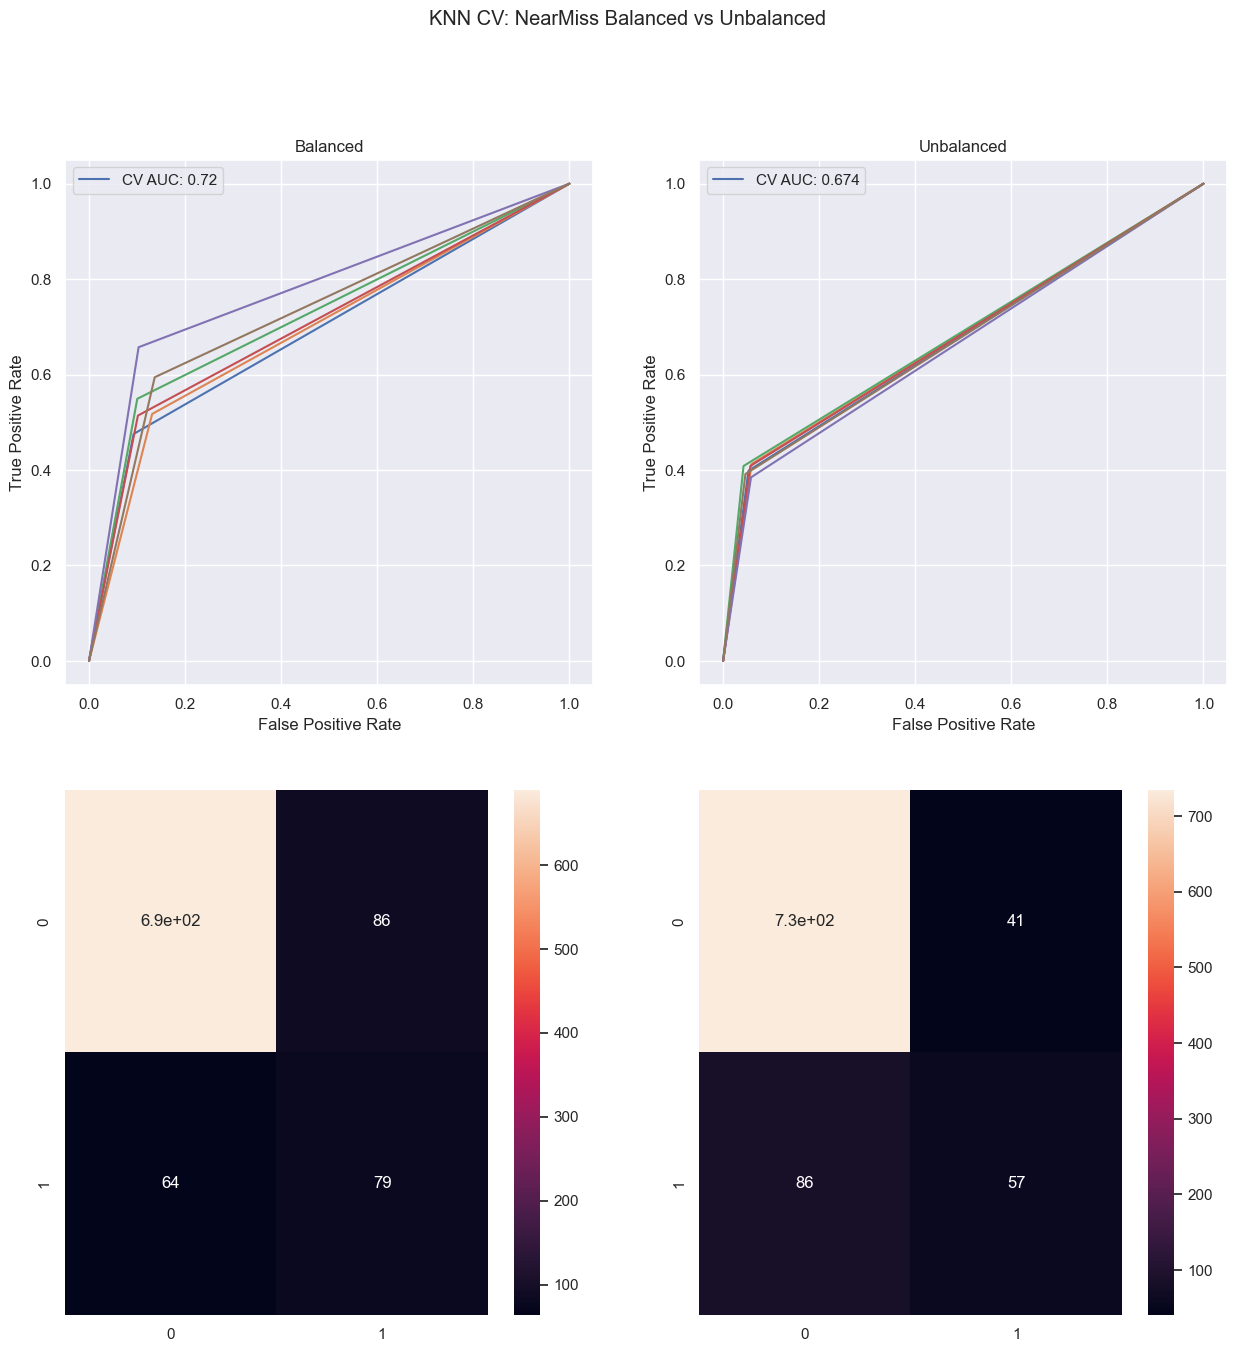

In [99]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle(f'KNN CV: NearMiss Balanced vs Unbalanced')
sns.set(font_scale = 1)

cflist = []
cflist_resampled = []
for res_resampled, res in zip(results_resampled, results):

    fpr, tpr, _ = roc_curve(res_resampled[0],  res_resampled[1])
    auc = roc_auc_score(res_resampled[0],  res_resampled[1])
    cf = confusion_matrix(res_resampled[0],  res_resampled[1])
    cflist_resampled.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,0])
    axes[0,0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,0].set_title('Balanced')

    
    
    fpr, tpr, _ = roc_curve(res[0],  res[1])
    auc = roc_auc_score(res[0],  res[1])
    cf = confusion_matrix(res[0],  res[1])
    cflist.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,1])
    axes[0,1].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,1].set_title('Unbalanced')
    
    
axes[0,0].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][0],3)}"])
axes[0,1].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][1],3)}"])

cf = np.mean(cflist,axis=0)
cf_resampled = np.mean(cflist_resampled,axis=0)
sns.heatmap(pd.DataFrame(cf_resampled) , annot=True, ax = axes[1,0])
sns.heatmap(pd.DataFrame(cf) , annot=True, ax = axes[1,1])   
plt.show()

    

# SVM

### SMOTE Oversampling

In [100]:
Xnorm_new.shape

(5510, 10)

In [101]:
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)
metrics_resampled = [[],[],[],[]]
metrics = [[],[],[],[]]
results_resampled = []
results = []
Xtrain0 = np.array(Xnorm_new)
ytrain0 = np.array(y)
for train_ix, test_ix in kfold.split(Xtrain0, ytrain0):
    # select rows
    train_X, test_X = Xtrain0[train_ix], Xtrain0[test_ix]
    train_y, test_y = ytrain0[train_ix], ytrain0[test_ix]
    
    # train unbalanced
    svm_unbalanced = SVC(kernel='rbf', class_weight = 'balanced', gamma=0.001, random_state=0)
    svm_unbalanced.fit(train_X, train_y)
    ypred = svm_unbalanced.predict(test_X)
    
    metrics = store_metrics(metrics, test_y, ypred)
    results.append([test_y, ypred])
    
    
    # train balanced 
    Xtrain_resampled0, ytrain_resampled0 = smote.fit_resample(train_X, train_y)
    svm_balanced = SVC(kernel='rbf', C = 0.03, gamma='auto', random_state=0)
    svm_balanced.fit(Xtrain_resampled0, ytrain_resampled0)
    ypred_resampled = svm_balanced.predict(test_X)
    
    metrics_resampled = store_metrics(metrics_resampled, test_y, ypred_resampled)
    results_resampled.append([test_y, ypred_resampled])
    
    
    



In [102]:
metrics_resampled = np.array(metrics_resampled)
metrics = np.array(metrics)
results_resampled = np.array(results_resampled)
results = np.array(results)

columns_resampled = ['ROC_AUC_resampled','F1_resampled','Precision_resampled','Recall_resampled']
columns = ['ROC_AUC','F1','Precision','Recall']
metrics_scores = pd.DataFrame(np.concatenate([metrics_resampled.T, metrics.T],axis=1), columns = columns_resampled + columns)
mean_score = np.mean(np.array(metrics_scores), axis=0)
mean_score0 = pd.DataFrame(mean_score.round(3).reshape(2,4), columns = columns, index=['Balanced','Unbalanced'])
mean_score0


ROC_AUC     F1  Precision  Recall
Balanced      0.777  0.524      0.398   0.769
Unbalanced    0.775  0.525      0.402   0.757

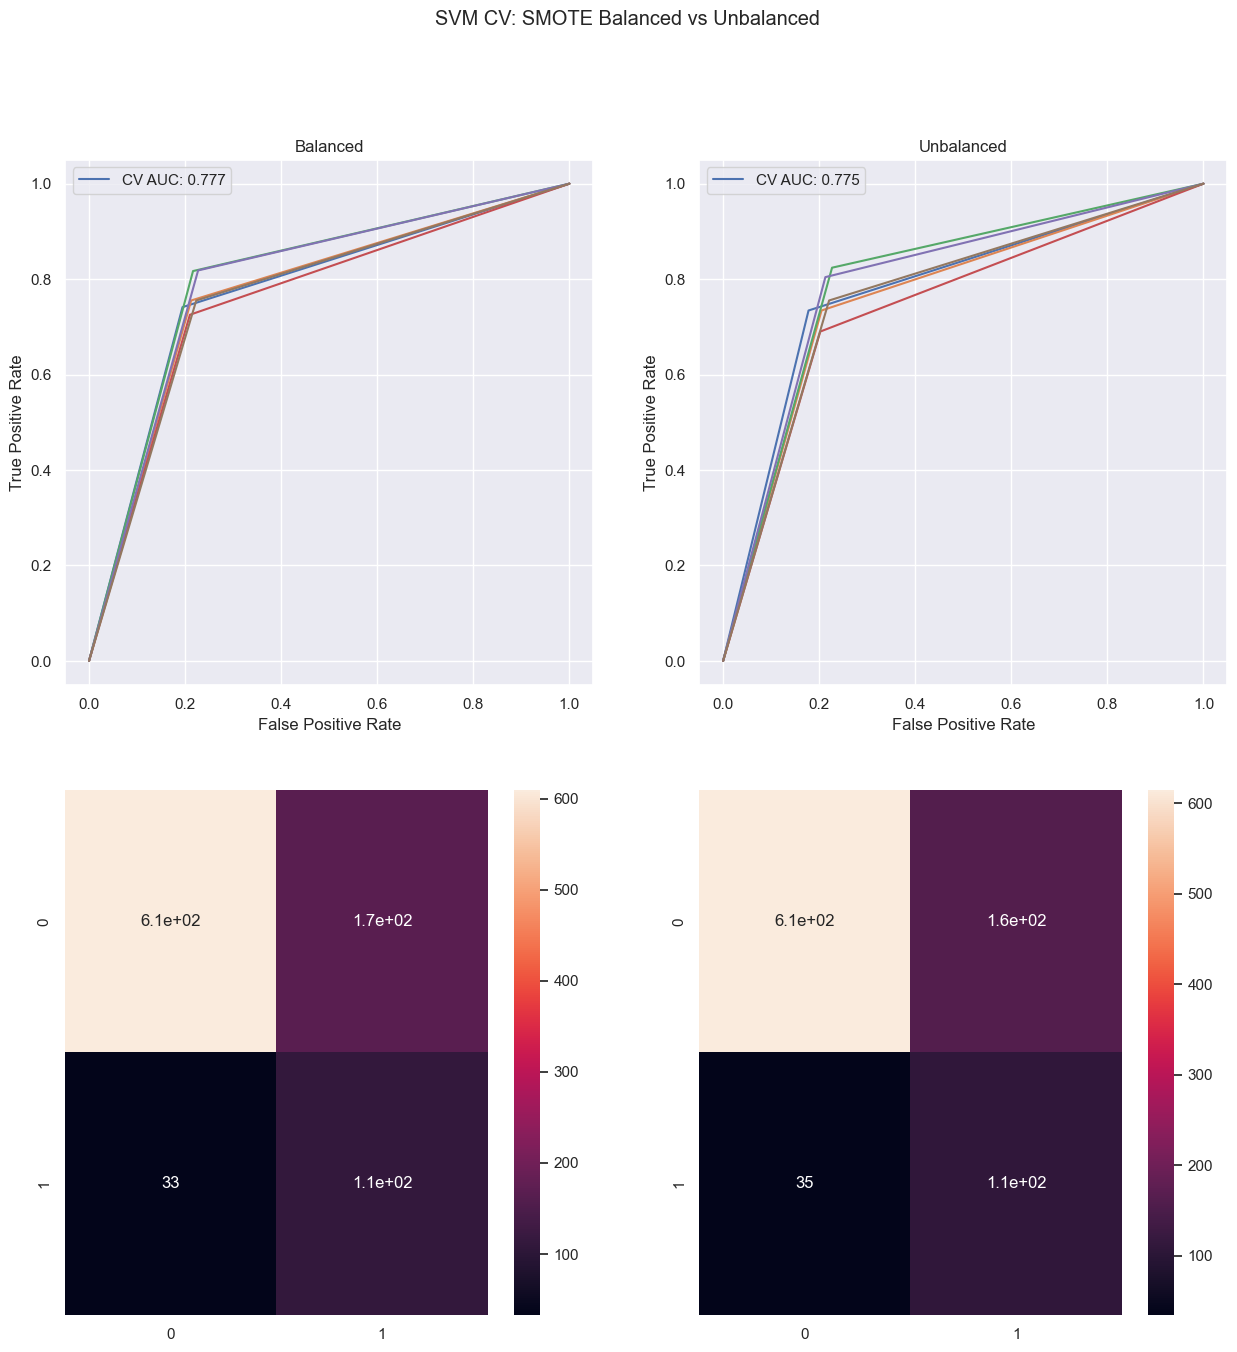

In [103]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle(f'SVM CV: SMOTE Balanced vs Unbalanced')
sns.set(font_scale = 1)

cflist = []
cflist_resampled = []
for res_resampled, res in zip(results_resampled, results):

    fpr, tpr, _ = roc_curve(res_resampled[0],  res_resampled[1])
    auc = roc_auc_score(res_resampled[0],  res_resampled[1])
    cf = confusion_matrix(res_resampled[0],  res_resampled[1])
    cflist_resampled.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,0])
    axes[0,0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,0].set_title('Balanced')

    
    
    fpr, tpr, _ = roc_curve(res[0],  res[1])
    auc = roc_auc_score(res[0],  res[1])
    cf = confusion_matrix(res[0],  res[1])
    cflist.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,1])
    axes[0,1].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,1].set_title('Unbalanced')
    
    
axes[0,0].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][0],3)}"])
axes[0,1].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][1],3)}"])

cf = np.mean(cflist,axis=0)
cf_resampled = np.mean(cflist_resampled,axis=0)
sns.heatmap(pd.DataFrame(cf_resampled) , annot=True, ax = axes[1,0])
sns.heatmap(pd.DataFrame(cf) , annot=True, ax = axes[1,1])   
plt.show()
    
    

### NearMiss Undersampling

In [104]:
from imblearn.under_sampling import NearMiss
nm = NearMiss()


In [105]:
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)
metrics_resampled = [[],[],[],[]]
metrics = [[],[],[],[]]
results_resampled = []
results = []
Xtrain0 = np.array(Xnorm_new)
ytrain0 = np.array(y)
for train_ix, test_ix in kfold.split(Xtrain0, ytrain0):
    # select rows
    train_X, test_X = Xtrain0[train_ix], Xtrain0[test_ix]
    train_y, test_y = ytrain0[train_ix], ytrain0[test_ix]
    
    # train unbalanced
    svm_unbalanced = SVC(kernel='rbf', class_weight = 'balanced', gamma=0.001)
    svm_unbalanced.fit(train_X, train_y)
    ypred = svm_unbalanced.predict(test_X)
    
    metrics = store_metrics(metrics, test_y, ypred)
    results.append([test_y, ypred])
    
    
    # train balanced 
    Xtrain_resampled0, ytrain_resampled0 = nm.fit_resample(train_X, train_y)
    svm_balanced = SVC(kernel='rbf', class_weight = 'balanced' , gamma=0.001)
    svm_balanced.fit(Xtrain_resampled0, ytrain_resampled0)
    ypred_resampled = svm_balanced.predict(test_X)
    
    metrics_resampled = store_metrics(metrics_resampled, test_y, ypred_resampled)
    results_resampled.append([test_y, ypred_resampled])
    
    
    



In [106]:
metrics_resampled = np.array(metrics_resampled)
metrics = np.array(metrics)
results_resampled = np.array(results_resampled)
results = np.array(results)

columns_resampled = ['ROC_AUC_resampled','F1_resampled','Precision_resampled','Recall_resampled']
columns = ['ROC_AUC','F1','Precision','Recall']
metrics_scores = pd.DataFrame(np.concatenate([metrics_resampled.T, metrics.T],axis=1), columns = columns_resampled + columns)
mean_score = np.mean(np.array(metrics_scores), axis=0)
mean_score0 = pd.DataFrame(mean_score.round(3).reshape(2,4), columns = columns, index=['Balanced','Unbalanced'])
mean_score0


ROC_AUC     F1  Precision  Recall
Balanced      0.747  0.501      0.395   0.687
Unbalanced    0.775  0.525      0.402   0.757

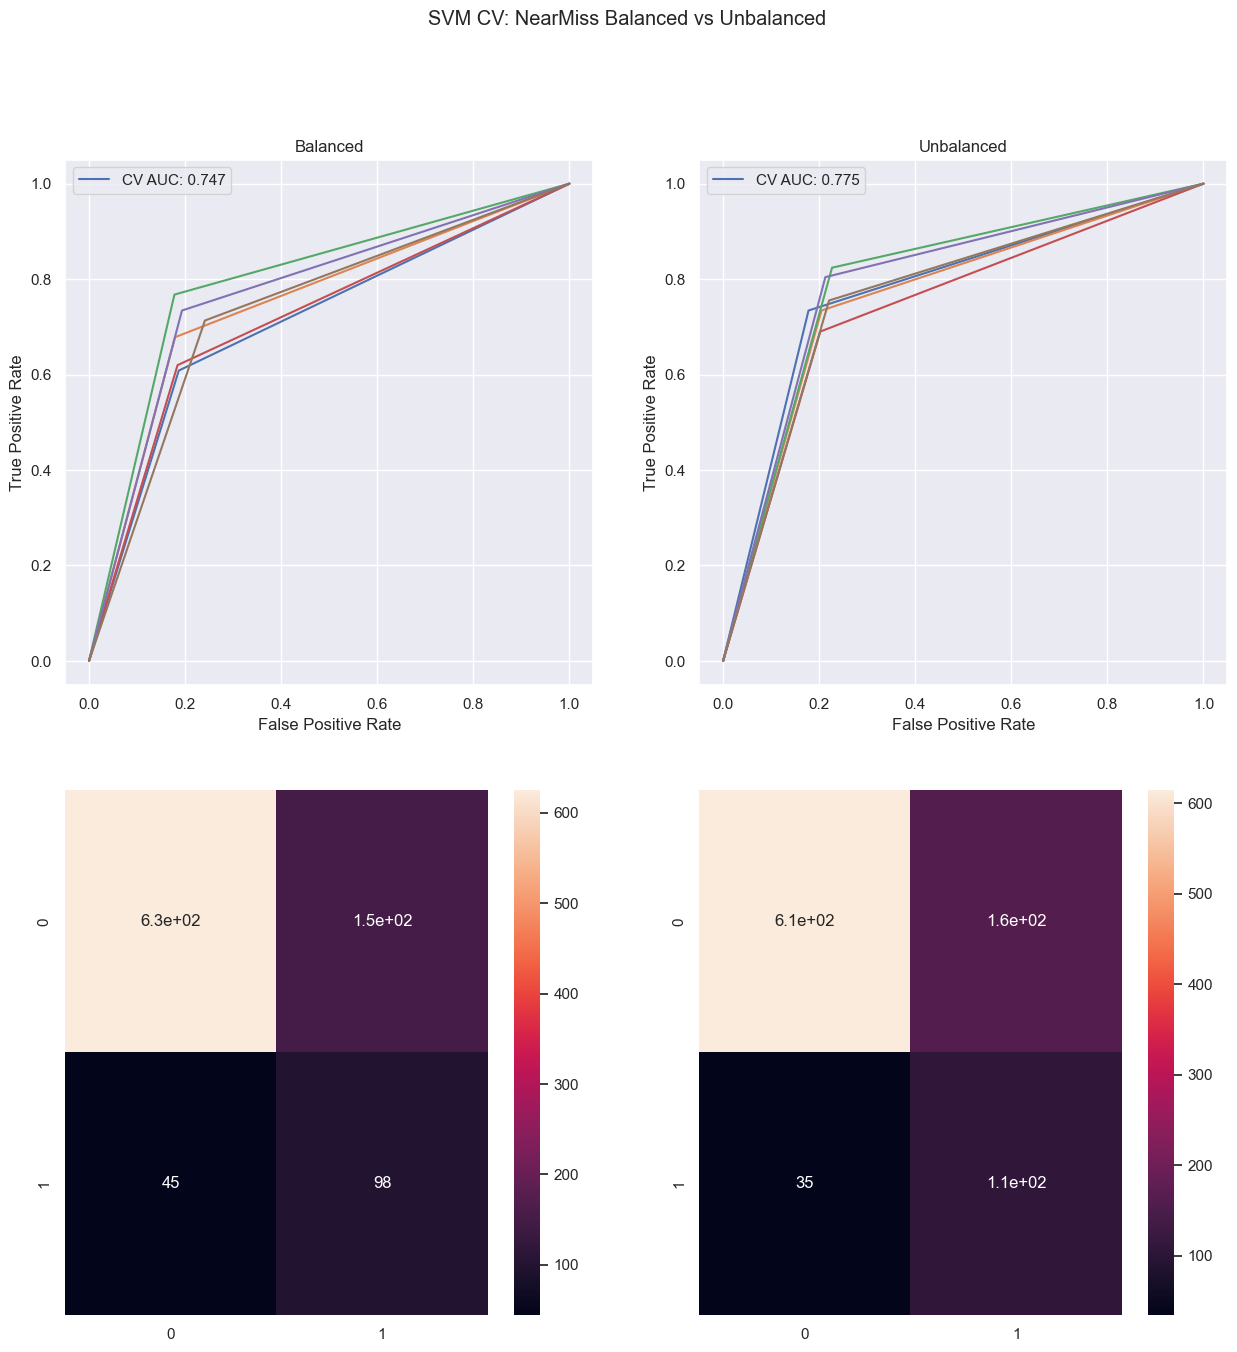

In [107]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle(f'SVM CV: NearMiss Balanced vs Unbalanced')
sns.set(font_scale = 1)

cflist = []
cflist_resampled = []
for res_resampled, res in zip(results_resampled, results):

    fpr, tpr, _ = roc_curve(res_resampled[0],  res_resampled[1])
    auc = roc_auc_score(res_resampled[0],  res_resampled[1])
    cf = confusion_matrix(res_resampled[0],  res_resampled[1])
    cflist_resampled.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,0])
    axes[0,0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,0].set_title('Balanced')

    
    
    fpr, tpr, _ = roc_curve(res[0],  res[1])
    auc = roc_auc_score(res[0],  res[1])
    cf = confusion_matrix(res[0],  res[1])
    cflist.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,1])
    axes[0,1].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,1].set_title('Unbalanced')
    
    
axes[0,0].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][0],3)}"])
axes[0,1].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][1],3)}"])

cf = np.mean(cflist,axis=0)
cf_resampled = np.mean(cflist_resampled,axis=0)
sns.heatmap(pd.DataFrame(cf_resampled) , annot=True, ax = axes[1,0])
sns.heatmap(pd.DataFrame(cf) , annot=True, ax = axes[1,1])   
plt.show()

    

# Classification Trees

### SMOTE Oversampling

In [108]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_new, y, test_size=0.2, random_state=13)
Xtrain_resampled, ytrain_resampled = smote.fit_resample(Xtrain, ytrain)

In [109]:
Xtrain_resampled.head()

Location    MinTemp  MaxTemp  Sunshine  Humidity9am  Humidity3pm  \
0        14   8.700000     24.4      12.2         60.0         29.0   
1        22   4.000000     17.9       8.8         70.0         52.0   
2        20  11.200000     24.0      10.4         57.0         28.0   
3        18  11.900000     36.0      12.9         71.0         18.0   
4        23  11.947429     23.2      10.5         60.0         50.5   

   Pressure9am  Pressure3pm    Temp9am    Temp3pm  
0       1012.8       1007.4  14.100000  23.600000  
1       1020.1       1017.3   9.000000  15.600000  
2       1017.2       1015.1  16.300000  23.300000  
3       1014.3       1009.3  18.100000  34.100000  
4       1020.3       1017.2  17.417549  23.838398

In [110]:
classi_tree = DecisionTreeClassifier(random_state=2, criterion='gini', class_weight='balanced')
classi_tree = classi_tree.fit(Xtrain_resampled, ytrain_resampled)
classi_tree.fit(Xtrain_resampled, ytrain_resampled)

ypred_resampled = classi_tree.predict(Xtest)
scores = classification_report(ytest, ypred_resampled)
roc_auc = roc_auc_score(ytest, ypred_resampled)
print('\t\t\t====Balanced===')
print(scores)
print(f'roc_auc score: {roc_auc}')

			====Balanced===
              precision    recall  f1-score   support

           0       0.91      0.85      0.88       934
           1       0.41      0.56      0.47       168

    accuracy                           0.81      1102
   macro avg       0.66      0.71      0.68      1102
weighted avg       0.84      0.81      0.82      1102

roc_auc score: 0.7058861017640461


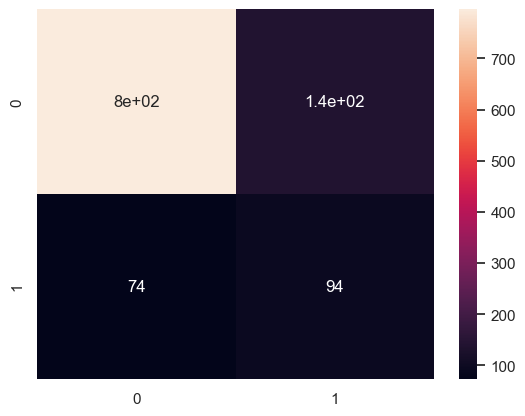

In [111]:
cf = confusion_matrix(ytest,  ypred_resampled)
sns.heatmap(pd.DataFrame(cf) , annot=True)
plt.show()

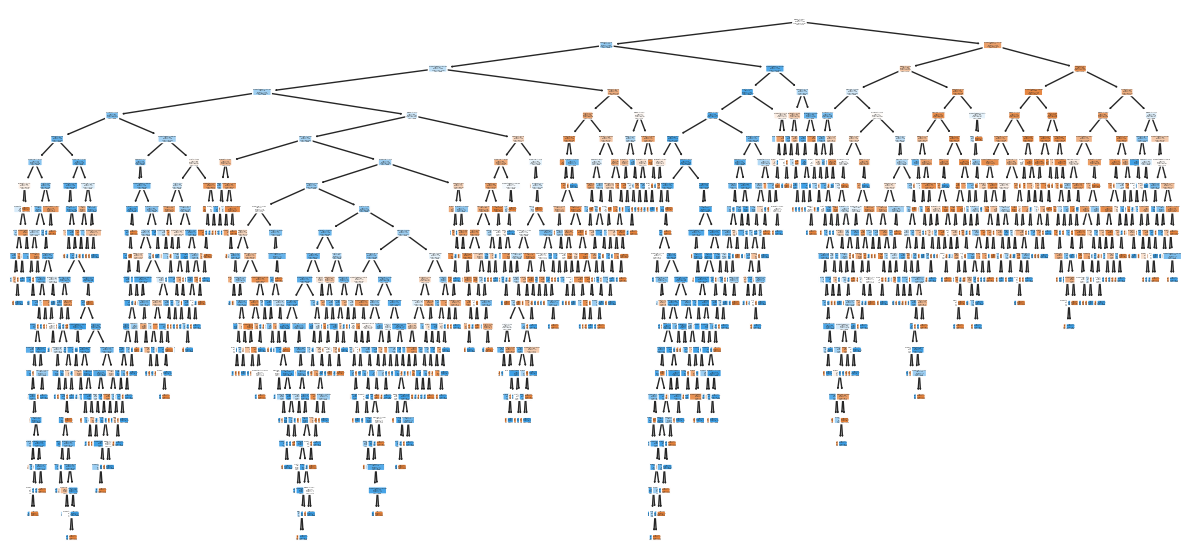

In [112]:
plt.figure(figsize=(15, 7))
plot_tree(classi_tree,
          filled=True,
          rounded=True,
          class_names=['Alive','Dead'],
          feature_names=X.columns)
plt.show()

###  Tuning CV

In [113]:
path = classi_tree.cost_complexity_pruning_path(Xtrain_resampled, ytrain_resampled)
alphas = path.ccp_alphas
ccp_alphas = alphas[:-1] #exclude the maximum value of alpha bc it leads to the the root of the tree

alpha_values = []
for a in alphas:
    classi_tree = DecisionTreeClassifier(random_state=0, ccp_alpha = a, criterion='gini', class_weight='balanced')
    scores_crossval = cross_val_score(classi_tree, Xtrain_resampled, ytrain_resampled, cv=5, scoring='roc_auc', n_jobs=-1)
    alpha_values.append([a, np.mean(scores_crossval), np.std(scores_crossval)])
    

    
alpha_results = pd.DataFrame(alpha_values, columns=['alpha', 'roc_auc', 'std'])
best_alpha = alpha_results.sort_values(by='roc_auc', ascending=False).iloc[0,0]
print(f'Best alpha: {best_alpha}')

Best alpha: 0.0006119829506926284


In [114]:
classi_tree_pruned = DecisionTreeClassifier(random_state = 2, ccp_alpha=best_alpha, criterion='gini', class_weight='balanced')
classi_tree_pruned.fit(Xtrain_resampled, ytrain_resampled)

#===========balanced
ypred = classi_tree_pruned.predict(Xtest)
scores = classification_report(ytest, ypred)
roc_auc = roc_auc_score(ytest, ypred)
print('\t\t\t====Balanced===')
print(scores)
print(f'roc_auc score: {roc_auc}')

			====Balanced===
              precision    recall  f1-score   support

           0       0.94      0.81      0.87       934
           1       0.40      0.69      0.51       168

    accuracy                           0.80      1102
   macro avg       0.67      0.75      0.69      1102
weighted avg       0.85      0.80      0.82      1102

roc_auc score: 0.7526256755378811


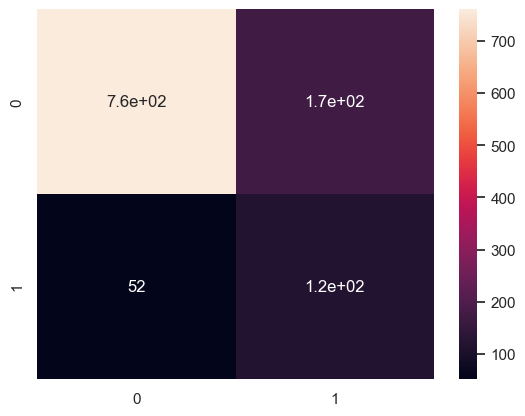

In [115]:
cf = confusion_matrix(ytest,  ypred)
sns.heatmap(pd.DataFrame(cf) , annot=True)
plt.show()

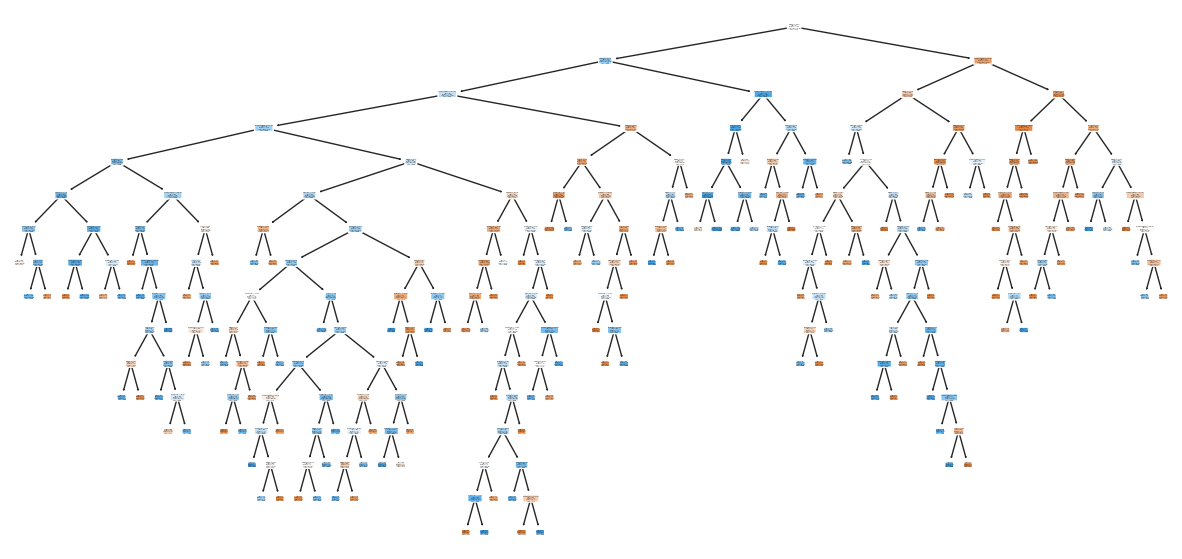

In [116]:
plt.figure(figsize=(15, 7))
plot_tree(classi_tree_pruned,
          filled=True,
          rounded=True,
          class_names=['Alive','Dead'],
          feature_names=X.columns)
plt.show()

### NearMiss Undersampling

In [117]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_new, y, test_size=0.2, random_state=13)
Xtrain_resampled, ytrain_resampled = nm.fit_resample(Xtrain, ytrain)
Xtrain.head()

Location    MinTemp  MaxTemp  Sunshine  Humidity9am  Humidity3pm  \
65847         14   8.700000     24.4      12.2         60.0         29.0   
39758         22   4.000000     17.9       8.8         70.0         52.0   
31451         20  11.200000     24.0      10.4         57.0         28.0   
79412         18  11.900000     36.0      12.9         71.0         18.0   
110796        23  11.947429     23.2      10.5         60.0         50.5   

        Pressure9am  Pressure3pm    Temp9am    Temp3pm  
65847        1012.8       1007.4  14.100000  23.600000  
39758        1020.1       1017.3   9.000000  15.600000  
31451        1017.2       1015.1  16.300000  23.300000  
79412        1014.3       1009.3  18.100000  34.100000  
110796       1020.3       1017.2  17.417549  23.838398

In [118]:
classi_tree = DecisionTreeClassifier(random_state=2, criterion='gini', class_weight='balanced')
classi_tree = classi_tree.fit(Xtrain_resampled, ytrain_resampled)
classi_tree.fit(Xtrain_resampled, ytrain_resampled)

ypred_resampled = classi_tree.predict(Xtest)
scores = classification_report(ytest, ypred_resampled)
roc_auc = roc_auc_score(ytest, ypred_resampled)
print('\t\t\t====Balanced===')
print(scores)
print(f'roc_auc score: {roc_auc}')

			====Balanced===
              precision    recall  f1-score   support

           0       0.89      0.48      0.62       934
           1       0.19      0.68      0.30       168

    accuracy                           0.51      1102
   macro avg       0.54      0.58      0.46      1102
weighted avg       0.79      0.51      0.57      1102

roc_auc score: 0.5799492709289283


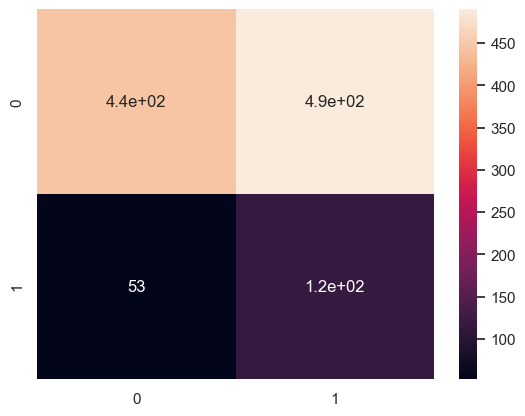

In [119]:
cf = confusion_matrix(ytest,  ypred_resampled)
sns.heatmap(pd.DataFrame(cf) , annot=True)
plt.show()

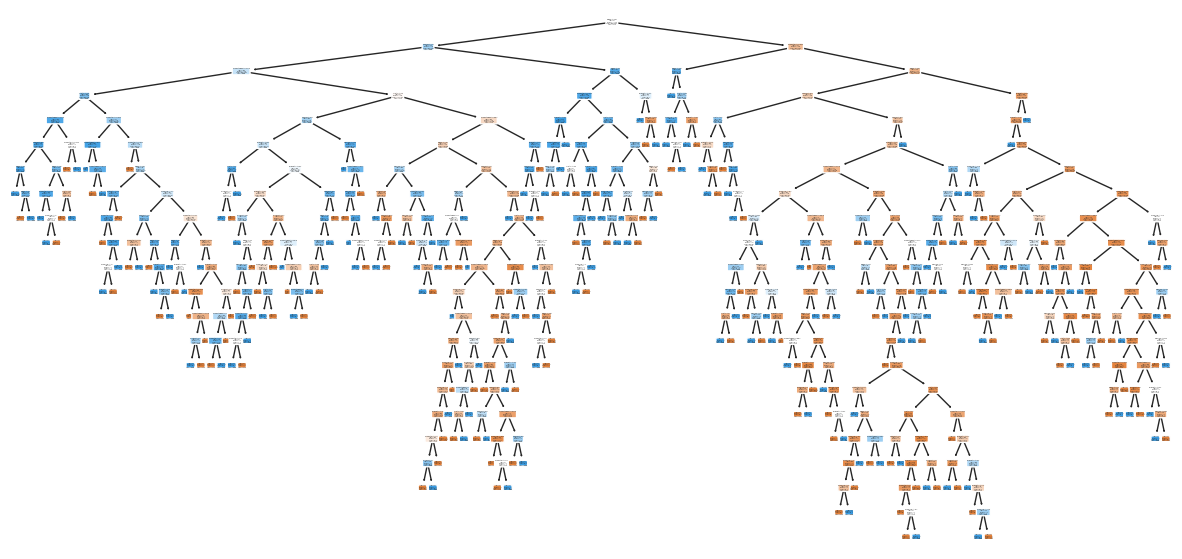

In [120]:
plt.figure(figsize=(15, 7))
plot_tree(classi_tree,
          filled=True,
          rounded=True,
          class_names=['Alive','Dead'],
          feature_names=X.columns)
plt.show()

### Tuning CV

In [121]:
path = classi_tree.cost_complexity_pruning_path(Xtrain_resampled, ytrain_resampled)
alphas = path.ccp_alphas
ccp_alphas = alphas[:-1] #exclude the maximum value of alpha bc it leads to the the root of the tree

alpha_values = []
for a in alphas:
    classi_tree = DecisionTreeClassifier(random_state=0, ccp_alpha = a, criterion='gini', class_weight='balanced')
    scores_crossval = cross_val_score(classi_tree, Xtrain_resampled, ytrain_resampled, cv=5, scoring='roc_auc', n_jobs=-1)
    alpha_values.append([a, np.mean(scores_crossval), np.std(scores_crossval)])
    

    
alpha_results = pd.DataFrame(alpha_values, columns=['alpha', 'roc_auc', 'std'])
best_alpha = alpha_results.sort_values(by='roc_auc', ascending=False).iloc[0,0]
print(f'Best alpha: {best_alpha}')

Best alpha: 0.005242309415913804


In [122]:
classi_tree_pruned = DecisionTreeClassifier(random_state = 2, ccp_alpha=best_alpha, criterion='gini', class_weight='balanced')
classi_tree_pruned.fit(Xtrain_resampled, ytrain_resampled)

#===========balanced
ypred = classi_tree_pruned.predict(Xtest)
scores = classification_report(ytest, ypred)
roc_auc = roc_auc_score(ytest, ypred)
print('\t\t\t====Balanced===')
print(scores)
print(f'roc_auc score: {roc_auc}')

			====Balanced===
              precision    recall  f1-score   support

           0       0.92      0.78      0.84       934
           1       0.33      0.61      0.43       168

    accuracy                           0.75      1102
   macro avg       0.62      0.69      0.63      1102
weighted avg       0.83      0.75      0.78      1102

roc_auc score: 0.6941279188334863


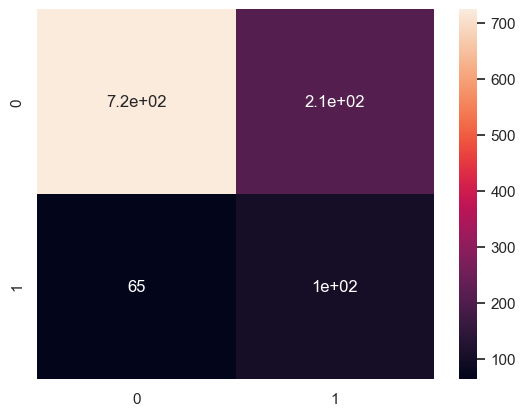

In [123]:
cf = confusion_matrix(ytest,  ypred)
sns.heatmap(pd.DataFrame(cf) , annot=True)
plt.show()

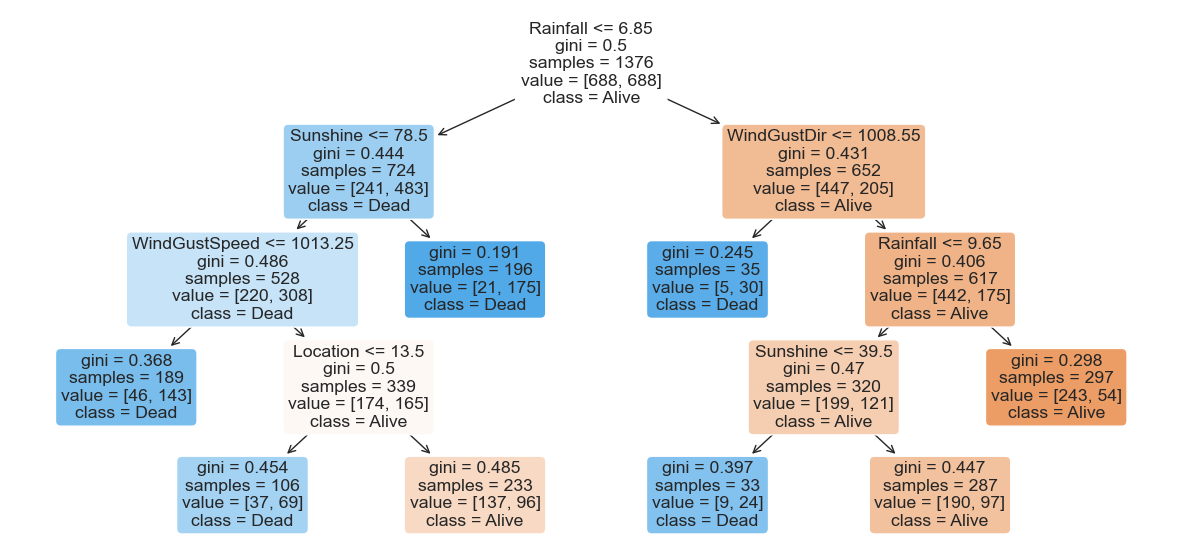

In [124]:
plt.figure(figsize=(15, 7))
plot_tree(classi_tree_pruned,
          filled=True,
          rounded=True,
          class_names=['Alive','Dead'],
          feature_names=X.columns)
plt.show()

### Unbalanced

In [125]:
Xtrain.shape

(4408, 10)

In [126]:
#===========unbalanced
classi_tree_unbalanced = DecisionTreeClassifier(random_state=2, criterion='entropy',class_weight='balanced' )
classi_tree_unbalanced = classi_tree_unbalanced.fit(Xtrain, ytrain)
classi_tree_unbalanced.fit(Xtrain, ytrain)

ypred = classi_tree_unbalanced.predict(Xtest)
scores = classification_report(ytest, ypred)
roc_auc = roc_auc_score(ytest, ypred)
print('\t\t\t====Balanced===')
print(scores)
print(f'roc_auc score: {roc_auc}')

			====Balanced===
              precision    recall  f1-score   support

           0       0.91      0.91      0.91       934
           1       0.48      0.48      0.48       168

    accuracy                           0.84      1102
   macro avg       0.70      0.69      0.69      1102
weighted avg       0.84      0.84      0.84      1102

roc_auc score: 0.6925920261038034


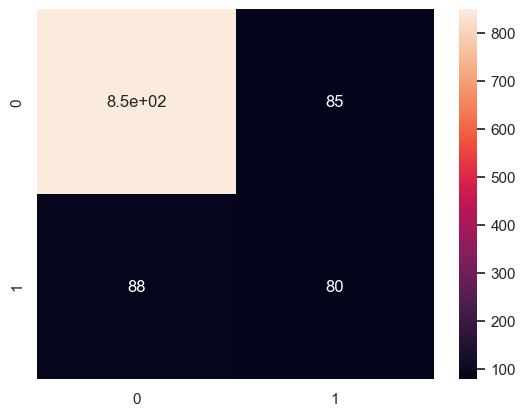

In [127]:
cf = confusion_matrix(ytest,  ypred)
sns.heatmap(pd.DataFrame(cf) , annot=True)
plt.show()

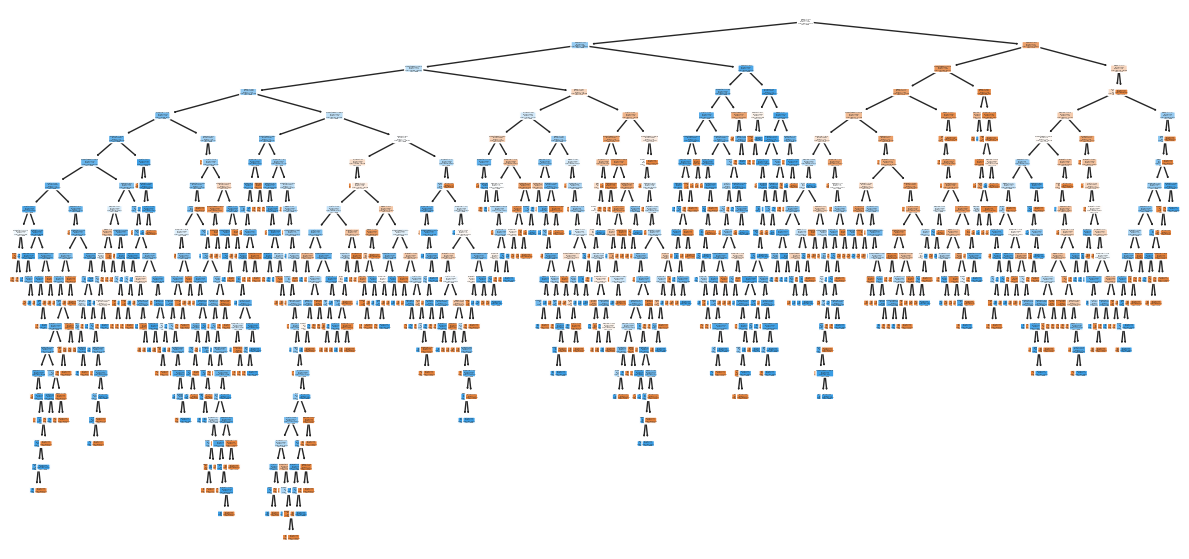

In [128]:

plt.figure(figsize=(15, 7))
plot_tree(classi_tree_unbalanced,
          filled=True,
          rounded=True,
          class_names=['Alive','Dead'],
          feature_names=X.columns)
plt.show()

### Unalanced Tuning CV

In [129]:
path = classi_tree_unbalanced.cost_complexity_pruning_path(Xtrain, ytrain)
alphas = path.ccp_alphas
ccp_alphas = alphas[:-1] #exclude the maximum value of alpha bc it leads to the the root of the tree

alpha_values = []
for a in alphas:
    classi_tree = DecisionTreeClassifier(random_state=0, ccp_alpha = a, criterion='entropy', class_weight='balanced')
    scores_crossval = cross_val_score(classi_tree, Xtrain, ytrain, cv=5, scoring='roc_auc', n_jobs=-1)
    alpha_values.append([a, np.mean(scores_crossval), np.std(scores_crossval)])
    

    
alpha_results = pd.DataFrame(alpha_values, columns=['alpha', 'roc_auc', 'std'])
best_alpha = alpha_results.sort_values(by='roc_auc', ascending=False).iloc[0,0]
print(f'Best alpha: {best_alpha}')

Best alpha: 0.007896625657378253


In [130]:
classi_tree_unbalanced_pruned = DecisionTreeClassifier(random_state = 2, ccp_alpha=best_alpha, criterion='entropy', class_weight='balanced')
classi_tree_unbalanced_pruned.fit(Xtrain, ytrain)

#===========balanced
ypred = classi_tree_unbalanced_pruned.predict(Xtest)
scores = classification_report(ytest, ypred)
roc_auc = roc_auc_score(ytest, ypred)
print('\t\t\t====Unbalanced===')
print(scores)
print(f'roc_auc score: {roc_auc}')

			====Unbalanced===
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       934
           1       0.39      0.76      0.52       168

    accuracy                           0.78      1102
   macro avg       0.67      0.77      0.69      1102
weighted avg       0.86      0.78      0.81      1102

roc_auc score: 0.7725158050372183


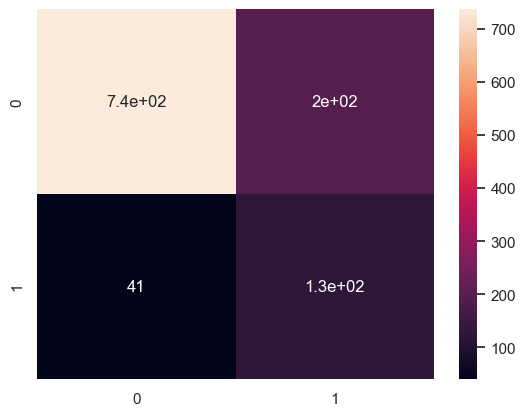

In [131]:
cf = confusion_matrix(ytest,  ypred)
sns.heatmap(pd.DataFrame(cf) , annot=True)
plt.show()

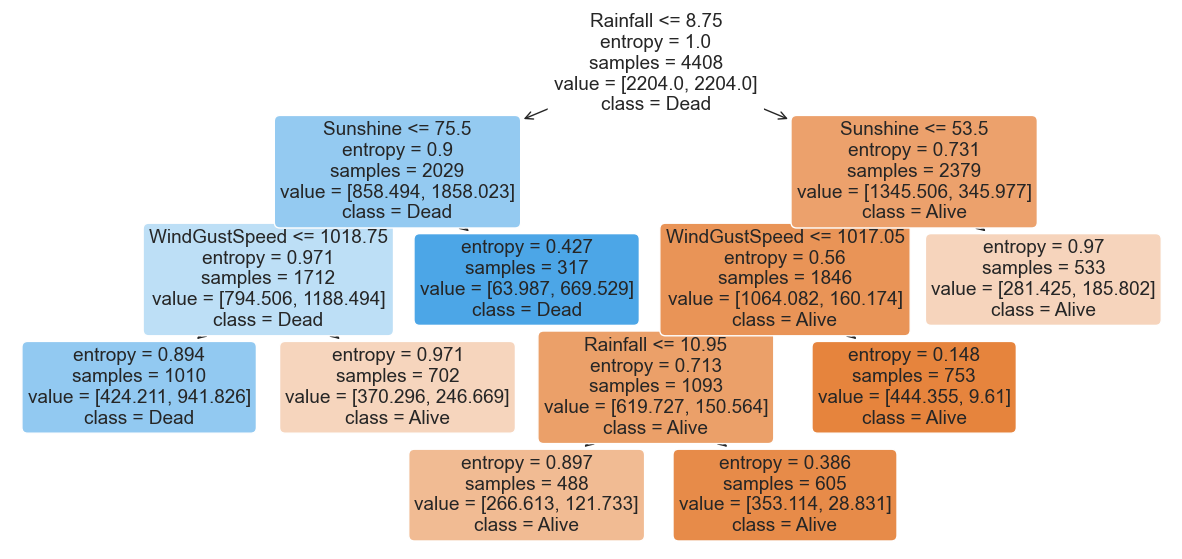

In [132]:
plt.figure(figsize=(15, 7))
plot_tree(classi_tree_unbalanced_pruned,
          filled=True,
          rounded=True,
          class_names=['Alive','Dead'],
          feature_names=X.columns)
plt.show()

# ANN

### SMOTE Oversampling

In [151]:
from tensorflow import keras
from tensorflow.keras import layers,Sequential
import tensorflow as tf

Xnorm_new = scale(X_new)
Xnorm_new = pd.DataFrame(Xnorm_new, columns=X_new.columns)

Xtrain, Xtest, ytrain, ytest = train_test_split(Xnorm_new, y, test_size=0.2, random_state=2)
Xtrain_resampled, ytrain_resampled = smote.fit_resample(Xtrain, ytrain)
Xtrain_resampled.head()

Location   MinTemp   MaxTemp  Sunshine  Humidity9am  Humidity3pm  \
0  1.131377 -0.241740 -0.315770 -0.861714    -0.619977    -0.015565   
1  0.651071 -1.124882 -1.061445  0.489206    -0.383685    -1.034959   
2  0.050689 -0.904097 -1.198405  0.434067    -0.501831    -0.015565   
3 -0.549693 -1.503372 -1.183187 -1.330400     0.325191     1.486700   
4  0.410918  0.294453 -0.224463 -0.641155     1.093140     0.950177   

   Pressure9am  Pressure3pm   Temp9am   Temp3pm  
0    -0.395680     0.227408 -0.143839 -0.696176  
1     0.586340     0.337711 -1.494252 -0.930129  
2    -0.078899    -0.040472 -1.180203 -1.288858  
3     0.047813     0.227408 -1.164500 -1.756766  
4    -0.617426     0.117104  0.028888 -0.306253

In [152]:
model=tf.keras.Sequential([
    layers.Flatten(input_shape=(X_new.shape[1], )),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256,activation='relu'),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 10)                0         
                                                                 
 dense_21 (Dense)            (None, 64)                704       
                                                                 
 dense_22 (Dense)            (None, 64)                4160      
                                                                 
 dropout_9 (Dropout)         (None, 64)                0         
                                                                 
 dense_23 (Dense)            (None, 128)               8320      
                                                                 
 dense_24 (Dense)            (None, 128)               16512     
                                                                 
 dropout_10 (Dropout)        (None, 128)              

In [153]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy', 
              metrics=["AUC"])

callback = keras.callbacks.EarlyStopping(monitor='val_auc', patience=3)
history = model.fit(Xtrain_resampled, ytrain_resampled, 
        epochs=150,
        validation_data=(Xtest, ytest),
        batch_size=32, 
        callbacks=[callback],)

Epoch 1/150
233/233 [==============================] - 1s 3ms/step - loss: 0.6938 - auc: 0.5123 - val_loss: 0.6854 - val_auc: 0.6963
Epoch 2/150
233/233 [==============================] - 1s 3ms/step - loss: 0.6885 - auc: 0.5668 - val_loss: 0.6788 - val_auc: 0.7475
Epoch 3/150
233/233 [==============================] - 1s 2ms/step - loss: 0.6824 - auc: 0.6215 - val_loss: 0.6690 - val_auc: 0.7620
Epoch 4/150
233/233 [==============================] - 1s 2ms/step - loss: 0.6739 - auc: 0.6664 - val_loss: 0.6556 - val_auc: 0.7743
Epoch 5/150
233/233 [==============================] - 1s 3ms/step - loss: 0.6612 - auc: 0.7047 - val_loss: 0.6406 - val_auc: 0.7888
Epoch 6/150
233/233 [==============================] - 1s 3ms/step - loss: 0.6427 - auc: 0.7325 - val_loss: 0.6147 - val_auc: 0.7995
Epoch 7/150
233/233 [==============================] - 1s 3ms/step - loss: 0.6232 - auc: 0.7478 - val_loss: 0.5895 - val_auc: 0.8132
Epoch 8/150
233/233 [==============================] - 1s 3ms/step - 

233/233 [==============================] - 1s 3ms/step - loss: 0.4591 - auc: 0.8640 - val_loss: 0.4519 - val_auc: 0.8653
Epoch 63/150
233/233 [==============================] - 1s 3ms/step - loss: 0.4616 - auc: 0.8619 - val_loss: 0.4509 - val_auc: 0.8655
Epoch 64/150
233/233 [==============================] - 1s 3ms/step - loss: 0.4599 - auc: 0.8634 - val_loss: 0.4507 - val_auc: 0.8655
Epoch 65/150
233/233 [==============================] - 1s 3ms/step - loss: 0.4602 - auc: 0.8633 - val_loss: 0.4512 - val_auc: 0.8656
Epoch 66/150
233/233 [==============================] - 1s 3ms/step - loss: 0.4592 - auc: 0.8651 - val_loss: 0.4536 - val_auc: 0.8659
Epoch 67/150
233/233 [==============================] - 1s 3ms/step - loss: 0.4582 - auc: 0.8641 - val_loss: 0.4516 - val_auc: 0.8659
Epoch 68/150
233/233 [==============================] - 1s 3ms/step - loss: 0.4605 - auc: 0.8630 - val_loss: 0.4492 - val_auc: 0.8660
Epoch 69/150
233/233 [==============================] - 1s 3ms/step - loss:

<AxesSubplot:title={'center':'Loss'}>

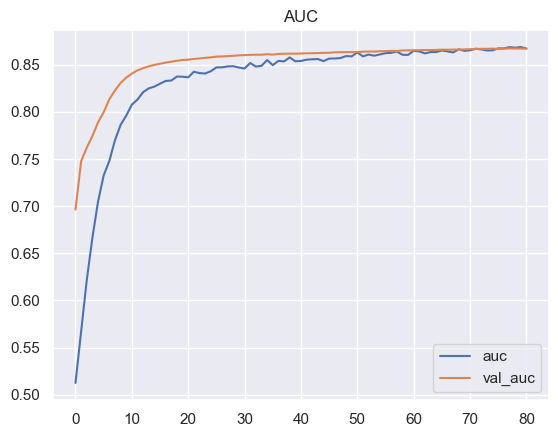

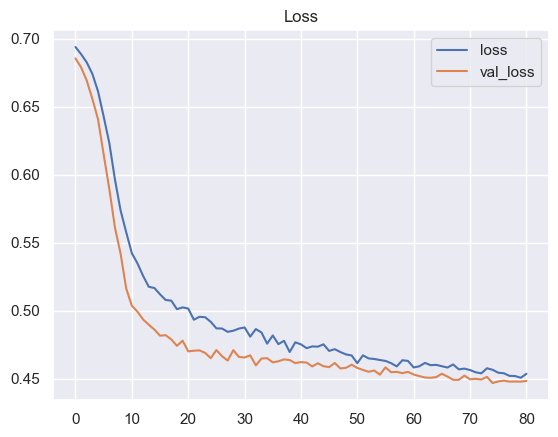

In [154]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['auc', 'val_auc']].plot(title="AUC")
history_df.loc[:, ['loss', 'val_loss']].plot(title="Loss")

35/35 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.95      0.76      0.84       929
           1       0.37      0.77      0.50       173

    accuracy                           0.76      1102
   macro avg       0.66      0.76      0.67      1102
weighted avg       0.86      0.76      0.79      1102



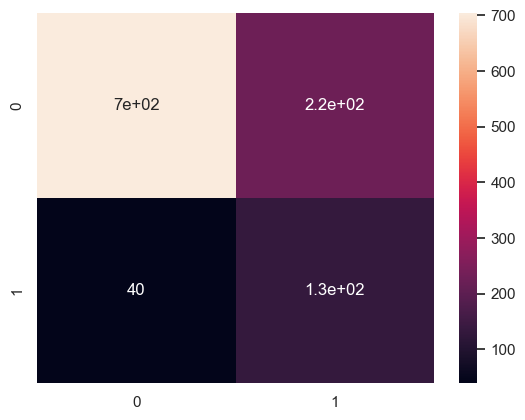

In [155]:
ypred = model.predict(Xtest)
cf = confusion_matrix(ytest, ypred.round())
sns.heatmap(pd.DataFrame(cf) , annot=True)
print(classification_report(ytest,ypred.round()))

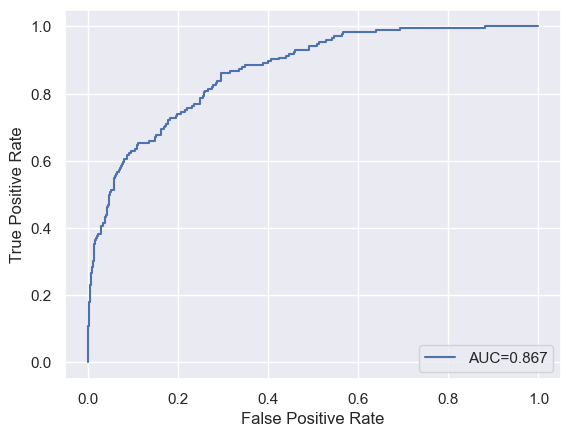

In [156]:
#create ROC curve
fpr, tpr, _ = roc_curve(ytest,  ypred)
auc = roc_auc_score(ytest, ypred)


plt.plot(fpr,tpr,label="AUC="+str(round(auc,3)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### NearMiss Undersampling

In [157]:
from tensorflow import keras
from tensorflow.keras import layers,Sequential
import tensorflow as tf

Xnorm_new = scale(X_new)
Xnorm_new = pd.DataFrame(Xnorm_new, columns=X_new.columns)

Xtrain, Xtest, ytrain, ytest = train_test_split(Xnorm_new, y, test_size=0.2, random_state=2)
Xtrain_resampled, ytrain_resampled = nm.fit_resample(Xtrain, ytrain)

In [158]:
model=tf.keras.Sequential([
    layers.Flatten(input_shape=(X_new.shape[1], )),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256,activation='relu'),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_4 (Flatten)         (None, 10)                0         
                                                                 
 dense_28 (Dense)            (None, 64)                704       
                                                                 
 dense_29 (Dense)            (None, 64)                4160      
                                                                 
 dropout_12 (Dropout)        (None, 64)                0         
                                                                 
 dense_30 (Dense)            (None, 128)               8320      
                                                                 
 dense_31 (Dense)            (None, 128)               16512     
                                                                 
 dropout_13 (Dropout)        (None, 128)              

In [159]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy', 
              metrics=["AUC"])

callback = keras.callbacks.EarlyStopping(monitor='val_auc', patience=3)
history = model.fit(Xtrain_resampled, ytrain_resampled, 
        epochs=150,
        validation_data=(Xtest, ytest),
        batch_size=32, 
        callbacks=[callback],)

Epoch 1/150
43/43 [==============================] - 1s 8ms/step - loss: 0.6986 - auc: 0.4599 - val_loss: 0.6931 - val_auc: 0.3919
Epoch 2/150
43/43 [==============================] - 0s 4ms/step - loss: 0.6993 - auc: 0.4569 - val_loss: 0.6955 - val_auc: 0.4259
Epoch 3/150
43/43 [==============================] - 0s 4ms/step - loss: 0.6939 - auc: 0.5149 - val_loss: 0.6978 - val_auc: 0.4540
Epoch 4/150
43/43 [==============================] - 0s 4ms/step - loss: 0.6974 - auc: 0.4667 - val_loss: 0.6993 - val_auc: 0.4903
Epoch 5/150
43/43 [==============================] - 0s 4ms/step - loss: 0.6946 - auc: 0.4999 - val_loss: 0.7014 - val_auc: 0.5183
Epoch 6/150
43/43 [==============================] - 0s 4ms/step - loss: 0.6915 - auc: 0.5314 - val_loss: 0.7033 - val_auc: 0.5558
Epoch 7/150
43/43 [==============================] - 0s 4ms/step - loss: 0.6924 - auc: 0.5284 - val_loss: 0.7032 - val_auc: 0.5568
Epoch 8/150
43/43 [==============================] - 0s 4ms/step - loss: 0.6902 - a

43/43 [==============================] - 0s 4ms/step - loss: 0.6273 - auc: 0.7211 - val_loss: 0.6673 - val_auc: 0.7094
Epoch 64/150
43/43 [==============================] - 0s 4ms/step - loss: 0.6210 - auc: 0.7185 - val_loss: 0.6677 - val_auc: 0.7115
Epoch 65/150
43/43 [==============================] - 0s 4ms/step - loss: 0.6292 - auc: 0.7210 - val_loss: 0.6646 - val_auc: 0.7119
Epoch 66/150
43/43 [==============================] - 0s 4ms/step - loss: 0.6232 - auc: 0.7253 - val_loss: 0.6634 - val_auc: 0.7135
Epoch 67/150
43/43 [==============================] - 0s 4ms/step - loss: 0.6205 - auc: 0.7211 - val_loss: 0.6609 - val_auc: 0.7151
Epoch 68/150
43/43 [==============================] - 0s 4ms/step - loss: 0.6167 - auc: 0.7379 - val_loss: 0.6584 - val_auc: 0.7159
Epoch 69/150
43/43 [==============================] - 0s 3ms/step - loss: 0.6271 - auc: 0.7164 - val_loss: 0.6548 - val_auc: 0.7168
Epoch 70/150
43/43 [==============================] - 0s 4ms/step - loss: 0.6272 - auc: 0

<AxesSubplot:title={'center':'Loss'}>

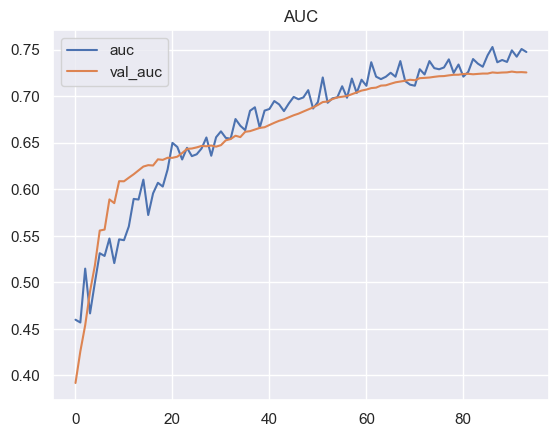

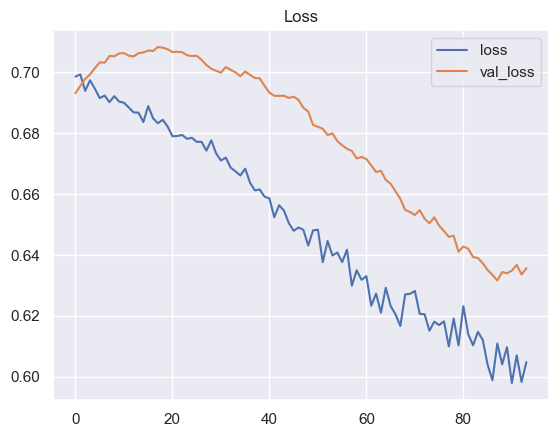

In [160]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['auc', 'val_auc']].plot(title="AUC")
history_df.loc[:, ['loss', 'val_loss']].plot(title="Loss")

35/35 [==============================] - 0s 919us/step
              precision    recall  f1-score   support

           0       0.93      0.63      0.75       929
           1       0.27      0.73      0.39       173

    accuracy                           0.65      1102
   macro avg       0.60      0.68      0.57      1102
weighted avg       0.82      0.65      0.70      1102



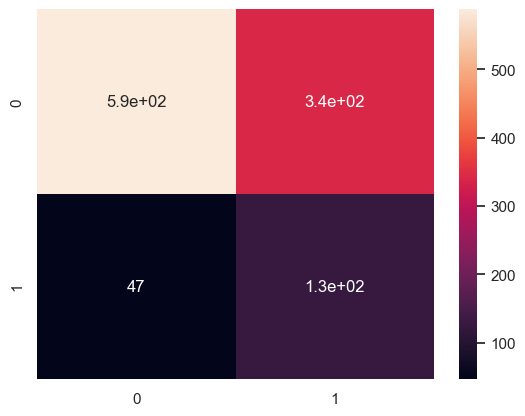

In [161]:
ypred = model.predict(Xtest)
cf = confusion_matrix(ytest, ypred.round())
sns.heatmap(pd.DataFrame(cf) , annot=True)
print(classification_report(ytest,ypred.round()))

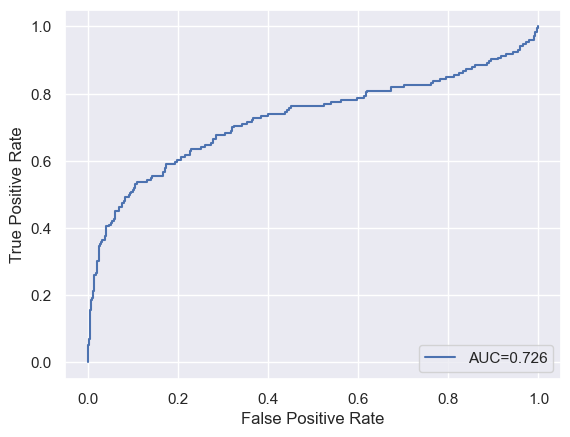

In [162]:
#create ROC curve
fpr, tpr, _ = roc_curve(ytest,  ypred)
auc = roc_auc_score(ytest, ypred)


plt.plot(fpr,tpr,label="AUC="+str(round(auc,3)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

### Unbalanced

In [163]:
Xnorm_new = scale(X_new)
Xnorm_new = pd.DataFrame(Xnorm_new, columns=X_new.columns)

Xtrain, Xtest, ytrain, ytest = train_test_split(Xnorm_new, y, test_size=0.2, random_state=2)
Xtrain_resampled, ytrain_resampled = smote.fit_resample(Xtrain, ytrain)

In [164]:
model=tf.keras.Sequential([
    layers.Flatten(input_shape=(X_new.shape[1], )),
    layers.Dense(64,activation='relu'),
    layers.Dense(64,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(128,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(256,activation='relu'),
    layers.Dense(256,activation='relu'),
    layers.Dropout(0.2),
    layers.Dense(1,activation='sigmoid')
])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_5 (Flatten)         (None, 10)                0         
                                                                 
 dense_35 (Dense)            (None, 64)                704       
                                                                 
 dense_36 (Dense)            (None, 64)                4160      
                                                                 
 dropout_15 (Dropout)        (None, 64)                0         
                                                                 
 dense_37 (Dense)            (None, 128)               8320      
                                                                 
 dense_38 (Dense)            (None, 128)               16512     
                                                                 
 dropout_16 (Dropout)        (None, 128)              

In [165]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss='binary_crossentropy', 
              metrics=["AUC"])

callback = keras.callbacks.EarlyStopping(monitor='val_auc', patience=3)
history = model.fit(Xtrain, ytrain, 
        epochs=150,
        validation_data=(Xtest, ytest),
        batch_size=32, 
        callbacks=[callback],)

Epoch 1/150
138/138 [==============================] - 1s 4ms/step - loss: 0.6325 - auc: 0.4309 - val_loss: 0.6271 - val_auc: 0.3669
Epoch 2/150
138/138 [==============================] - 0s 3ms/step - loss: 0.5606 - auc: 0.4596 - val_loss: 0.5735 - val_auc: 0.3860
Epoch 3/150
138/138 [==============================] - 0s 3ms/step - loss: 0.5094 - auc: 0.4432 - val_loss: 0.5284 - val_auc: 0.4315
Epoch 4/150
138/138 [==============================] - 0s 3ms/step - loss: 0.4786 - auc: 0.4603 - val_loss: 0.4961 - val_auc: 0.4833
Epoch 5/150
138/138 [==============================] - 0s 3ms/step - loss: 0.4608 - auc: 0.4976 - val_loss: 0.4750 - val_auc: 0.5313
Epoch 6/150
138/138 [==============================] - 0s 3ms/step - loss: 0.4514 - auc: 0.5208 - val_loss: 0.4602 - val_auc: 0.5772
Epoch 7/150
138/138 [==============================] - 0s 3ms/step - loss: 0.4423 - auc: 0.5492 - val_loss: 0.4498 - val_auc: 0.6160
Epoch 8/150
138/138 [==============================] - 0s 3ms/step - 

138/138 [==============================] - 0s 3ms/step - loss: 0.3411 - auc: 0.8205 - val_loss: 0.3240 - val_auc: 0.8512
Epoch 63/150
138/138 [==============================] - 0s 3ms/step - loss: 0.3343 - auc: 0.8302 - val_loss: 0.3238 - val_auc: 0.8507
Epoch 64/150
138/138 [==============================] - 0s 3ms/step - loss: 0.3401 - auc: 0.8195 - val_loss: 0.3238 - val_auc: 0.8514
Epoch 65/150
138/138 [==============================] - 0s 3ms/step - loss: 0.3366 - auc: 0.8248 - val_loss: 0.3233 - val_auc: 0.8508
Epoch 66/150
138/138 [==============================] - 0s 3ms/step - loss: 0.3388 - auc: 0.8228 - val_loss: 0.3234 - val_auc: 0.8515
Epoch 67/150
138/138 [==============================] - 0s 3ms/step - loss: 0.3373 - auc: 0.8263 - val_loss: 0.3230 - val_auc: 0.8514
Epoch 68/150
138/138 [==============================] - 0s 3ms/step - loss: 0.3371 - auc: 0.8257 - val_loss: 0.3228 - val_auc: 0.8513
Epoch 69/150
138/138 [==============================] - 0s 3ms/step - loss:

<AxesSubplot:title={'center':'Loss'}>

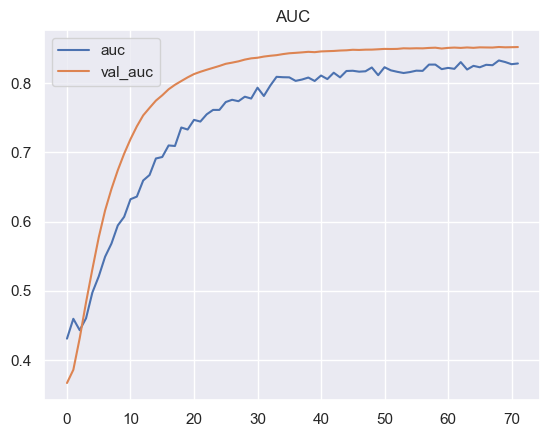

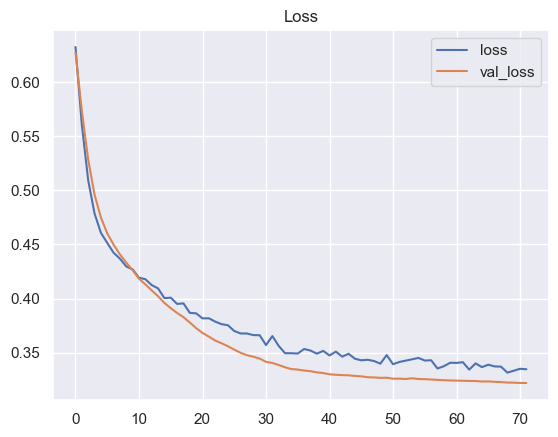

In [166]:
history_df = pd.DataFrame(history.history)
history_df.loc[:, ['auc', 'val_auc']].plot(title="AUC")
history_df.loc[:, ['loss', 'val_loss']].plot(title="Loss")

35/35 [==============================] - 0s 1ms/step
              precision    recall  f1-score   support

           0       0.91      0.95      0.93       929
           1       0.65      0.49      0.55       173

    accuracy                           0.88      1102
   macro avg       0.78      0.72      0.74      1102
weighted avg       0.87      0.88      0.87      1102



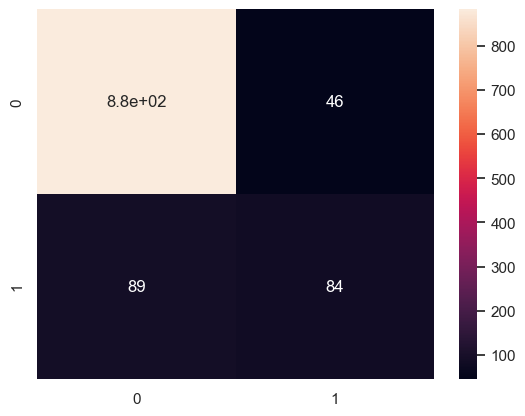

In [167]:
ypred = model.predict(Xtest)
cf = confusion_matrix(ytest, ypred.round())
sns.heatmap(pd.DataFrame(cf) , annot=True)
print(classification_report(ytest,ypred.round()))

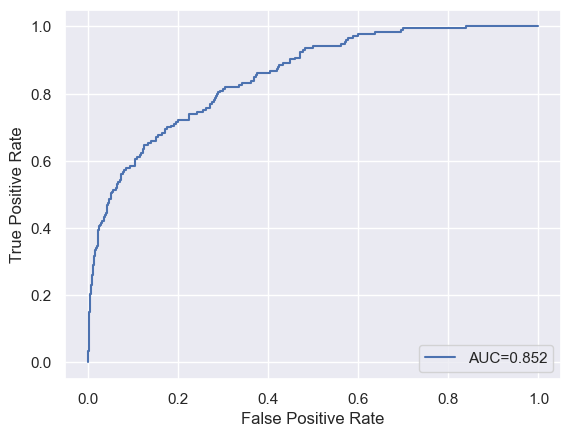

In [168]:
#create ROC curve
fpr, tpr, _ = roc_curve(ytest,  ypred)
auc = roc_auc_score(ytest, ypred)


plt.plot(fpr,tpr,label="AUC="+str(round(auc,3)))
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.show()

 # Rule Induction: RIPPER

### SMOTE Oversampling

In [191]:
import wittgenstein as witt
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import NearMiss


In [192]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_new, y, test_size=0.2, random_state=13)
Xtrain_resampled, ytrain_resampled = smote.fit_resample(Xtrain, ytrain)

In [194]:
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)
metrics_resampled = [[],[],[],[]]
metrics = [[],[],[],[]]
results_resampled = []
results = []
Xtrain0 = np.array(X_new)
ytrain0 = np.array(y)
for train_ix, test_ix in kfold.split(Xtrain0, ytrain0):
    # select rows
    train_X, test_X = Xtrain0[train_ix], Xtrain0[test_ix]
    train_y, test_y = ytrain0[train_ix], ytrain0[test_ix]
    
    # train unbalanced
    ripper = witt.RIPPER(prune_size=0.001, k=3, random_state=0, verbosity = 1)
    ripper.fit(train_X, train_y)
    ypred = ripper.predict(test_X)
    
    metrics = store_metrics(metrics, test_y, ypred)
    results.append([test_y, ypred])
    

    
    
    # train balanced 
    Xtrain_resampled0, ytrain_resampled0 = smote.fit_resample(train_X, train_y)
    ripper = witt.RIPPER(prune_size=0.001, k=3,random_state=0)
    ripper.fit(Xtrain_resampled0, ytrain_resampled0)
    ypred_resampled = ripper.predict(test_X)

    
    metrics_resampled = store_metrics(metrics_resampled, test_y, ypred_resampled)
    results_resampled.append([test_y, ypred_resampled])

    
    



discretizing 10 features

GREW INITIAL RULESET:
[[5=>72.0] V
[3=<2.1] V
[3=2.1-4.6] V
[3=4.6-6.6] V
[3=6.6-8.0] V
[3=8.0-9.1]]

optimization run 1 of 3

OPTIMIZED RULESET:
[[5=>72.0] V
[3=<2.1] V
[3=2.1-4.6] V
[3=4.6-6.6] V
[3=6.6-8.0] V
[3=8.0-9.1]]

No changes were made. Halting optimization.
GREW FINAL RULES
[[5=>72.0] V
[3=<2.1] V
[3=2.1-4.6] V
[3=4.6-6.6] V
[3=6.6-8.0] V
[3=8.0-9.1] V
[5=>72.0] V
[3=<2.1] V
[3=2.1-4.6] V
[3=4.6-6.6] V
[3=6.6-8.0] V
[3=8.0-9.1] V
[1=>21.3] V
[7=1007.8-1010.3] V
[3=9.1-9.9 ^ 0=23.0-26.0] V
[7=1010.3-1012.4]]

FINAL RULESET:
[[5=>72.0] V
[3=<2.1] V
[3=2.1-4.6] V
[3=9.1-9.9 ^ 0=23.0-26.0]]

discretizing 10 features

GREW INITIAL RULESET:
[[5=>72.0] V
[3=<2.1] V
[3=2.1-4.6] V
[3=4.6-6.6] V
[3=6.6-8.0] V
[3=8.0-9.1 ^ 7=1008.0-1010.5] V
[6=<1010.8] V
[6=1010.8-1013.2]]

optimization run 1 of 3

OPTIMIZED RULESET:
[[5=>72.0] V
[3=<2.1] V
[3=2.1-4.6] V
[3=4.6-6.6] V
[3=6.6-8.0] V
[3=8.0-9.1 ^ 7=1008.0-1010.5] V
[6=<1010.8] V
[6=1010.8-1013.2]]

No changes 

In [195]:
metrics_resampled = np.array(metrics_resampled)
metrics = np.array(metrics)
results_resampled = np.array(results_resampled)
results = np.array(results)

columns_resampled = ['ROC_AUC_resampled','F1_resampled','Precision_resampled','Recall_resampled']
columns = ['ROC_AUC','F1','Precision','Recall']
metrics_scores = pd.DataFrame(np.concatenate([metrics_resampled.T, metrics.T],axis=1), columns = columns_resampled + columns)
mean_score = np.mean(np.array(metrics_scores), axis=0)
mean_score0 = pd.DataFrame(mean_score.round(3).reshape(2,4), columns = columns, index=['Balanced','Unbalanced'])
mean_score0


ROC_AUC     F1  Precision  Recall
Balanced      0.730  0.448      0.317   0.769
Unbalanced    0.735  0.492      0.397   0.659

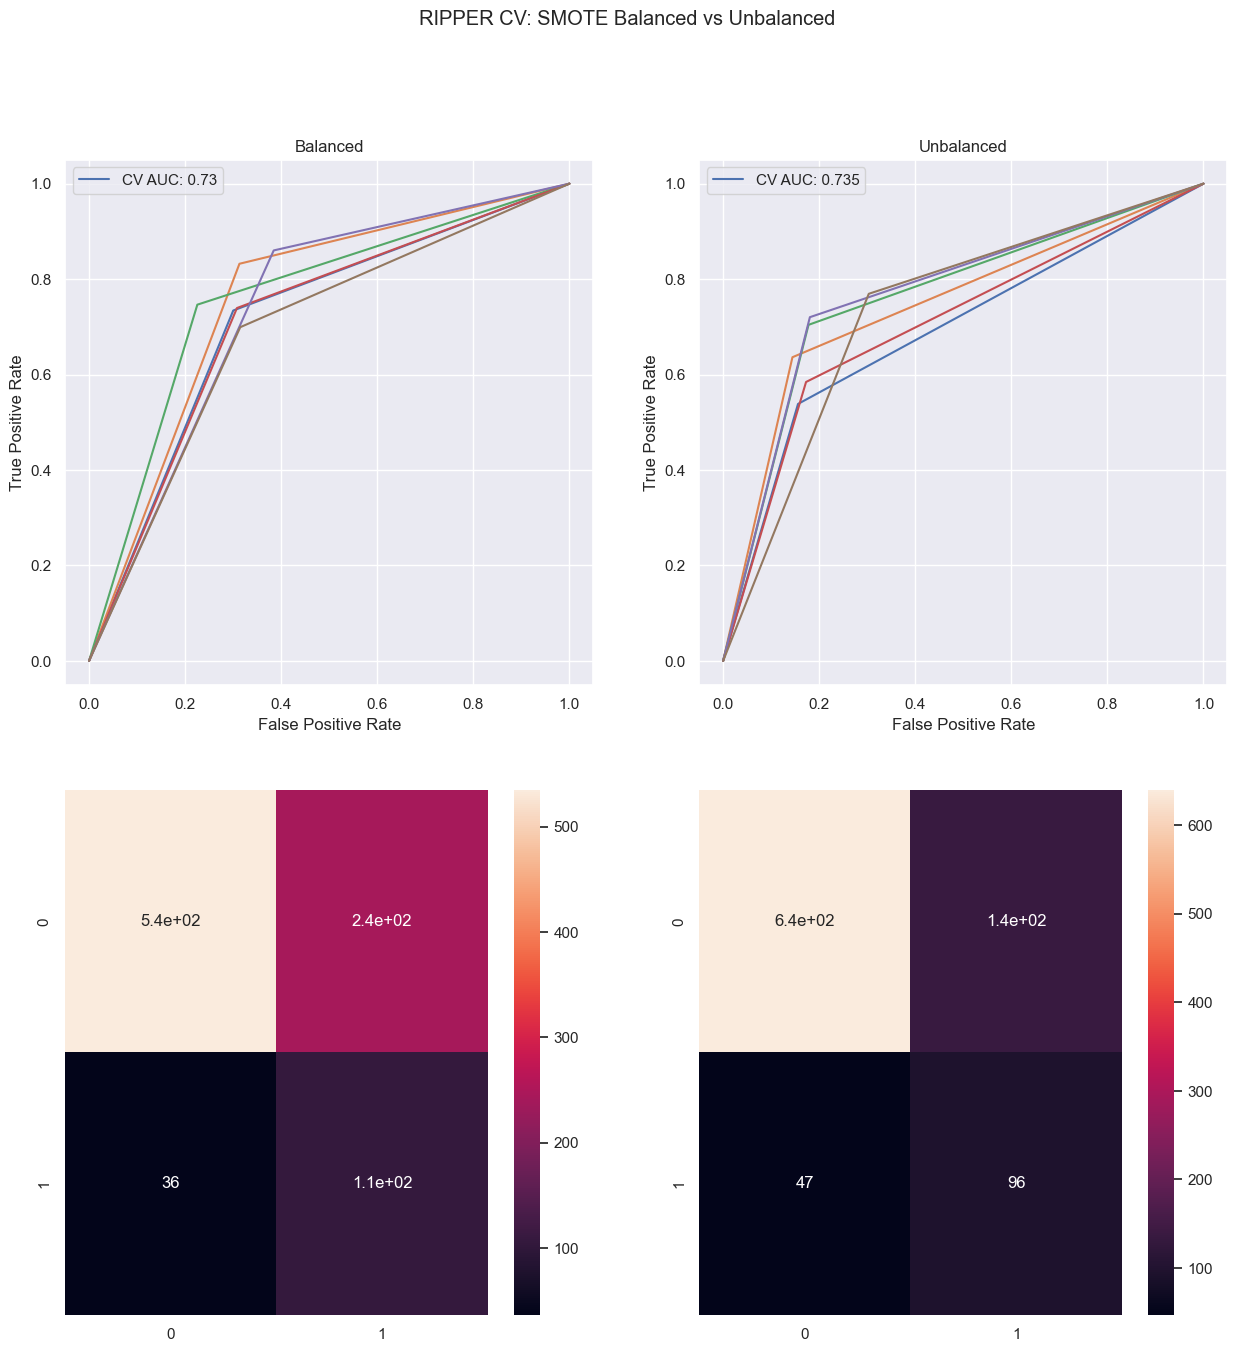

In [196]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle(f'RIPPER CV: SMOTE Balanced vs Unbalanced')
sns.set(font_scale = 1)

cflist = []
cflist_resampled = []
for res_resampled, res in zip(results_resampled, results):

    fpr, tpr, _ = roc_curve(res_resampled[0],  res_resampled[1])
    auc = roc_auc_score(res_resampled[0],  res_resampled[1])
    cf = confusion_matrix(res_resampled[0],  res_resampled[1])
    cflist_resampled.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,0])
    axes[0,0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,0].set_title('Balanced')

    
    
    fpr, tpr, _ = roc_curve(res[0],  res[1])
    auc = roc_auc_score(res[0],  res[1])
    cf = confusion_matrix(res[0],  res[1])
    cflist.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,1])
    axes[0,1].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,1].set_title('Unbalanced')
    
    
axes[0,0].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][0],3)}"])
axes[0,1].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][1],3)}"])

cf = np.median(cflist,axis=0)
cf_resampled = np.median(cflist_resampled,axis=0)
sns.heatmap(pd.DataFrame(cf_resampled) , annot=True, ax = axes[1,0])
sns.heatmap(pd.DataFrame(cf) , annot=True, ax = axes[1,1])   
plt.show()

    
    

### NearMiss Undersampling

In [187]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X_new, y, test_size=0.2, random_state=13)
Xtrain_resampled, ytrain_resampled = nm.fit_resample(Xtrain, ytrain)

In [188]:
kfold = StratifiedKFold(n_splits=6, shuffle=True, random_state=0)
metrics_resampled = [[],[],[],[]]
metrics = [[],[],[],[]]
results_resampled = []
results = []
Xtrain0 = np.array(X_new)
ytrain0 = np.array(y)
for train_ix, test_ix in kfold.split(Xtrain0, ytrain0):
    # select rows
    train_X, test_X = Xtrain0[train_ix], Xtrain0[test_ix]
    train_y, test_y = ytrain0[train_ix], ytrain0[test_ix]
    
    # train unbalanced
    ripper = witt.RIPPER(prune_size=0.001, k=3, random_state=0)
    ripper.fit(train_X, train_y)
    ypred = ripper.predict(test_X)
    
    metrics = store_metrics(metrics, test_y, ypred)
    results.append([test_y, ypred])
    

    
    
    # train balanced 
    Xtrain_resampled0, ytrain_resampled0 = nm.fit_resample(train_X, train_y)
    ripper = witt.RIPPER(prune_size=0.001, k=3,random_state=0)
    ripper.fit(Xtrain_resampled0, ytrain_resampled0)
    ypred_resampled = ripper.predict(test_X)

    
    metrics_resampled = store_metrics(metrics_resampled, test_y, ypred_resampled)
    results_resampled.append([test_y, ypred_resampled])

    
    



In [189]:
metrics_resampled = np.array(metrics_resampled)
metrics = np.array(metrics)
results_resampled = np.array(results_resampled)
results = np.array(results)

columns_resampled = ['ROC_AUC_resampled','F1_resampled','Precision_resampled','Recall_resampled']
columns = ['ROC_AUC','F1','Precision','Recall']
metrics_scores = pd.DataFrame(np.concatenate([metrics_resampled.T, metrics.T],axis=1), columns = columns_resampled + columns)
mean_score = np.mean(np.array(metrics_scores), axis=0)
mean_score0 = pd.DataFrame(mean_score.round(3).reshape(2,4), columns = columns, index=['Balanced','Unbalanced'])
mean_score0


ROC_AUC     F1  Precision  Recall
Balanced      0.568  0.301      0.196   0.685
Unbalanced    0.735  0.492      0.397   0.659

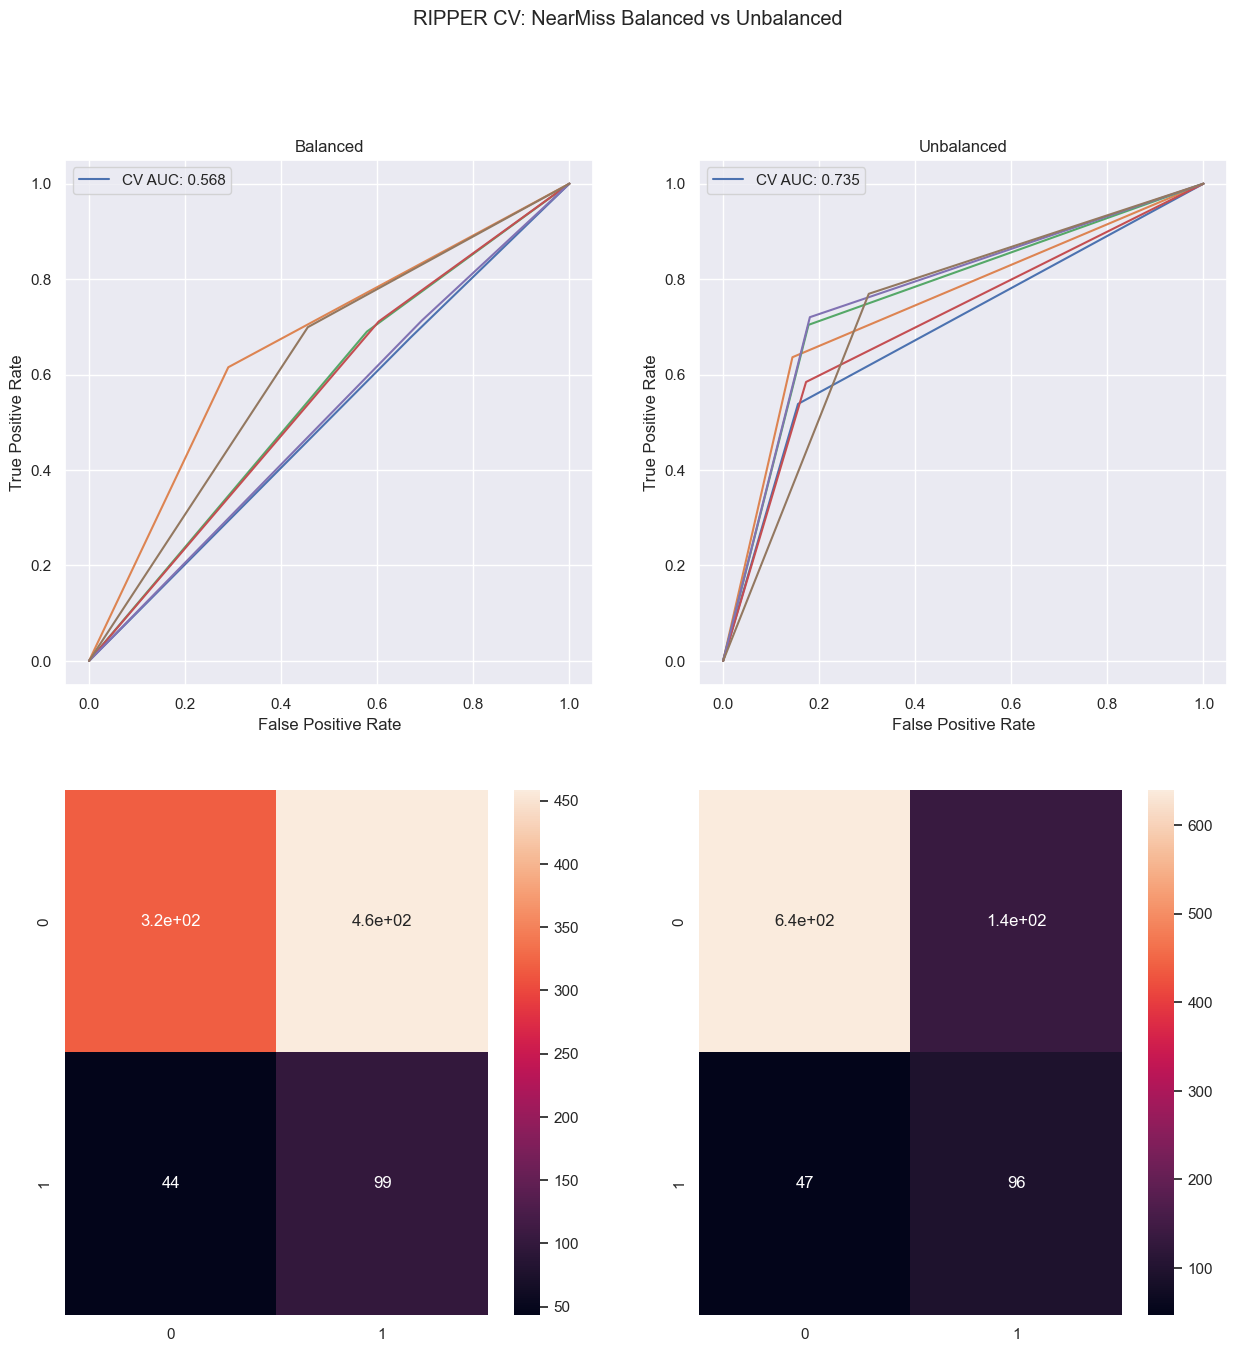

In [190]:
fig, axes = plt.subplots(2, 2, figsize=(15, 15))
fig.suptitle(f'RIPPER CV: NearMiss Balanced vs Unbalanced')
sns.set(font_scale = 1)

cflist = []
cflist_resampled = []
for res_resampled, res in zip(results_resampled, results):

    fpr, tpr, _ = roc_curve(res_resampled[0],  res_resampled[1])
    auc = roc_auc_score(res_resampled[0],  res_resampled[1])
    cf = confusion_matrix(res_resampled[0],  res_resampled[1])
    cflist_resampled.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,0])
    axes[0,0].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,0].set_title('Balanced')

    
    
    fpr, tpr, _ = roc_curve(res[0],  res[1])
    auc = roc_auc_score(res[0],  res[1])
    cf = confusion_matrix(res[0],  res[1])
    cflist.append(cf)
    sns.lineplot(x=fpr,y=tpr,ax = axes[0,1])
    axes[0,1].set(xlabel='False Positive Rate', ylabel='True Positive Rate')
    axes[0,1].set_title('Unbalanced')
    
    
axes[0,0].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][0],3)}"])
axes[0,1].legend([f"CV AUC: {round(mean_score0['ROC_AUC'][1],3)}"])

cf = np.median(cflist,axis=0)
cf_resampled = np.median(cflist_resampled,axis=0)
sns.heatmap(pd.DataFrame(cf_resampled) , annot=True, ax = axes[1,0])
sns.heatmap(pd.DataFrame(cf) , annot=True, ax = axes[1,1])   
plt.show()

    
    